#### CITS5508 Assignment 3
* _File          : assignment3.ipynb_
* _Contact       : 22056151@student.uwa.edu.au_
* _Author        : Suning (Juliet) Li_
<br><br>
* _Editor        : Visual Studio Code 1.77.0_
* _Python Version: 3.10.6_
* _Version       : 1.0_
<br><br>
* _License       : (C)Copyright Juliet_Li_2023_
* _Description   : This is the python notebook for CITS5508 assignment 3._
* _ModifyTime    : 25/05/2023_

<br> Please note a number of functions and code blocks in this notebook are leveraging assginment 1 and assignment 2.
<br><br> Please run this notebook top down without jumping sections.

# Section 1: A model for diagnosing cancer <br>

In [1]:
import pandas as pd

# Load the dataset
df_breast = pd.read_csv('breast-cancer.csv')

In [2]:
df_breast.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


### Task 1: Logistic regression and decision tree for tumour status prediction

##### Part 1: Investigation and Preparation of the data
* Change target value to numeric
* Check for missing values
* Check for feature correlation, remove highly correlated features
* Check separation of feature space
* Check distribution and balance of the feature space
* split the training and testing data
* feature scaling

In [3]:
# As the target value is text, we will convert it to numbers first
from sklearn.preprocessing import LabelEncoder

# Encode the diagnosis variable
le = LabelEncoder()
df_breast['diagnosis_text'] = df_breast['diagnosis']
df_breast['diagnosis'] = le.fit_transform(df_breast['diagnosis'])

# Get the list of classes by the encoder
classes = le.classes_
mapping = {label: integer for integer, label in enumerate(classes)}

print(mapping)

{'B': 0, 'M': 1}


In [4]:
# To see the total number of missing values in the entire DataFrame
features_breast = df_breast.columns[2:-1]

total_missing_values = df_breast[features_breast].isna().sum().sum()
print(f"\nTotal missing values in DataFrame: {total_missing_values}")


Total missing values in DataFrame: 0


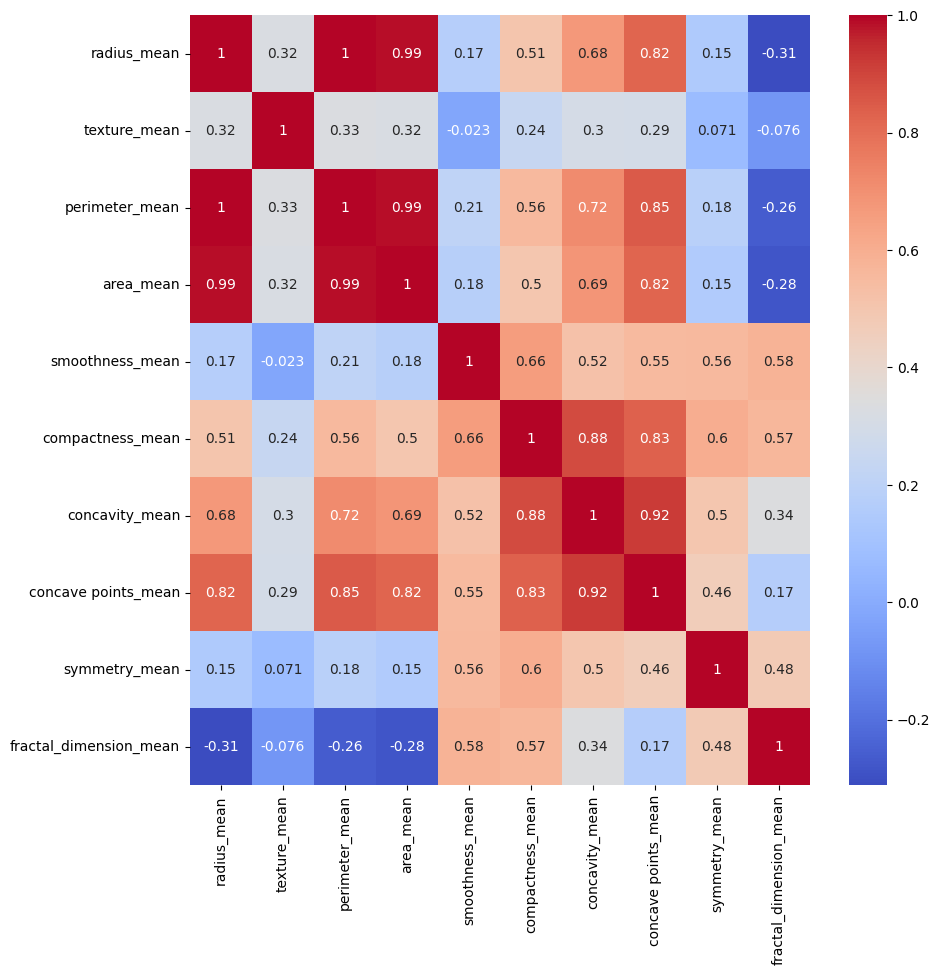

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting correlation heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(df_breast[features_breast].corr(), annot=True, cmap="coolwarm")
plt.show()

In reference to the plot above:
* A heat map of the correlation matrix between the 10 features is plotted.
* As can be seen, there are some features with above 0.9 correlation with each other. 
* radius_mean and perimeter_mean have the perfect correlation =1
* The features that are highly correlated need to be be dropped before training. 
* Reasons for why the correlated features need to be drop are explained in assignment 2, will not be explained again here. 
* The function wrote in assginment 2 will be used below to drop the correlated features. 

In [6]:
# define a function to drop highly correlated features
def drop_corr_features(correlation_threshold,correlation_matrix,df_feature):
    
    # Create a set for the features to be dropped
    features_to_drop = set()

    # Loop through the correlation matrix and identify the features that are highly correlated and are to be dropped
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) >= correlation_threshold:
                colname = correlation_matrix.columns[i]
                
                features_to_drop.add(colname)
                # #Print the highly correlated features 
                # print(colname, ',', correlation_matrix.index[j], ':', correlation_matrix.iloc[i, j])
    if len(features_to_drop) > 0:
        # Drop the features from the original dataframe
        df_feature_dropped = df_feature.drop(features_to_drop, axis=1)
    else:
        df_feature_dropped = df_feature

    # print the features that should be dropped as they are highly correlated with other features
    print(len(features_to_drop), 'features is dropped:',features_to_drop)

    return df_feature_dropped

In [7]:
# drop features that has higher correlation than 0.9 or lower than -0.9
df_feature_dropped = drop_corr_features(0.9,df_breast[features_breast].corr(),df_breast[features_breast])
features_dropped = df_feature_dropped.columns

3 features is dropped: {'area_mean', 'perimeter_mean', 'concave points_mean'}


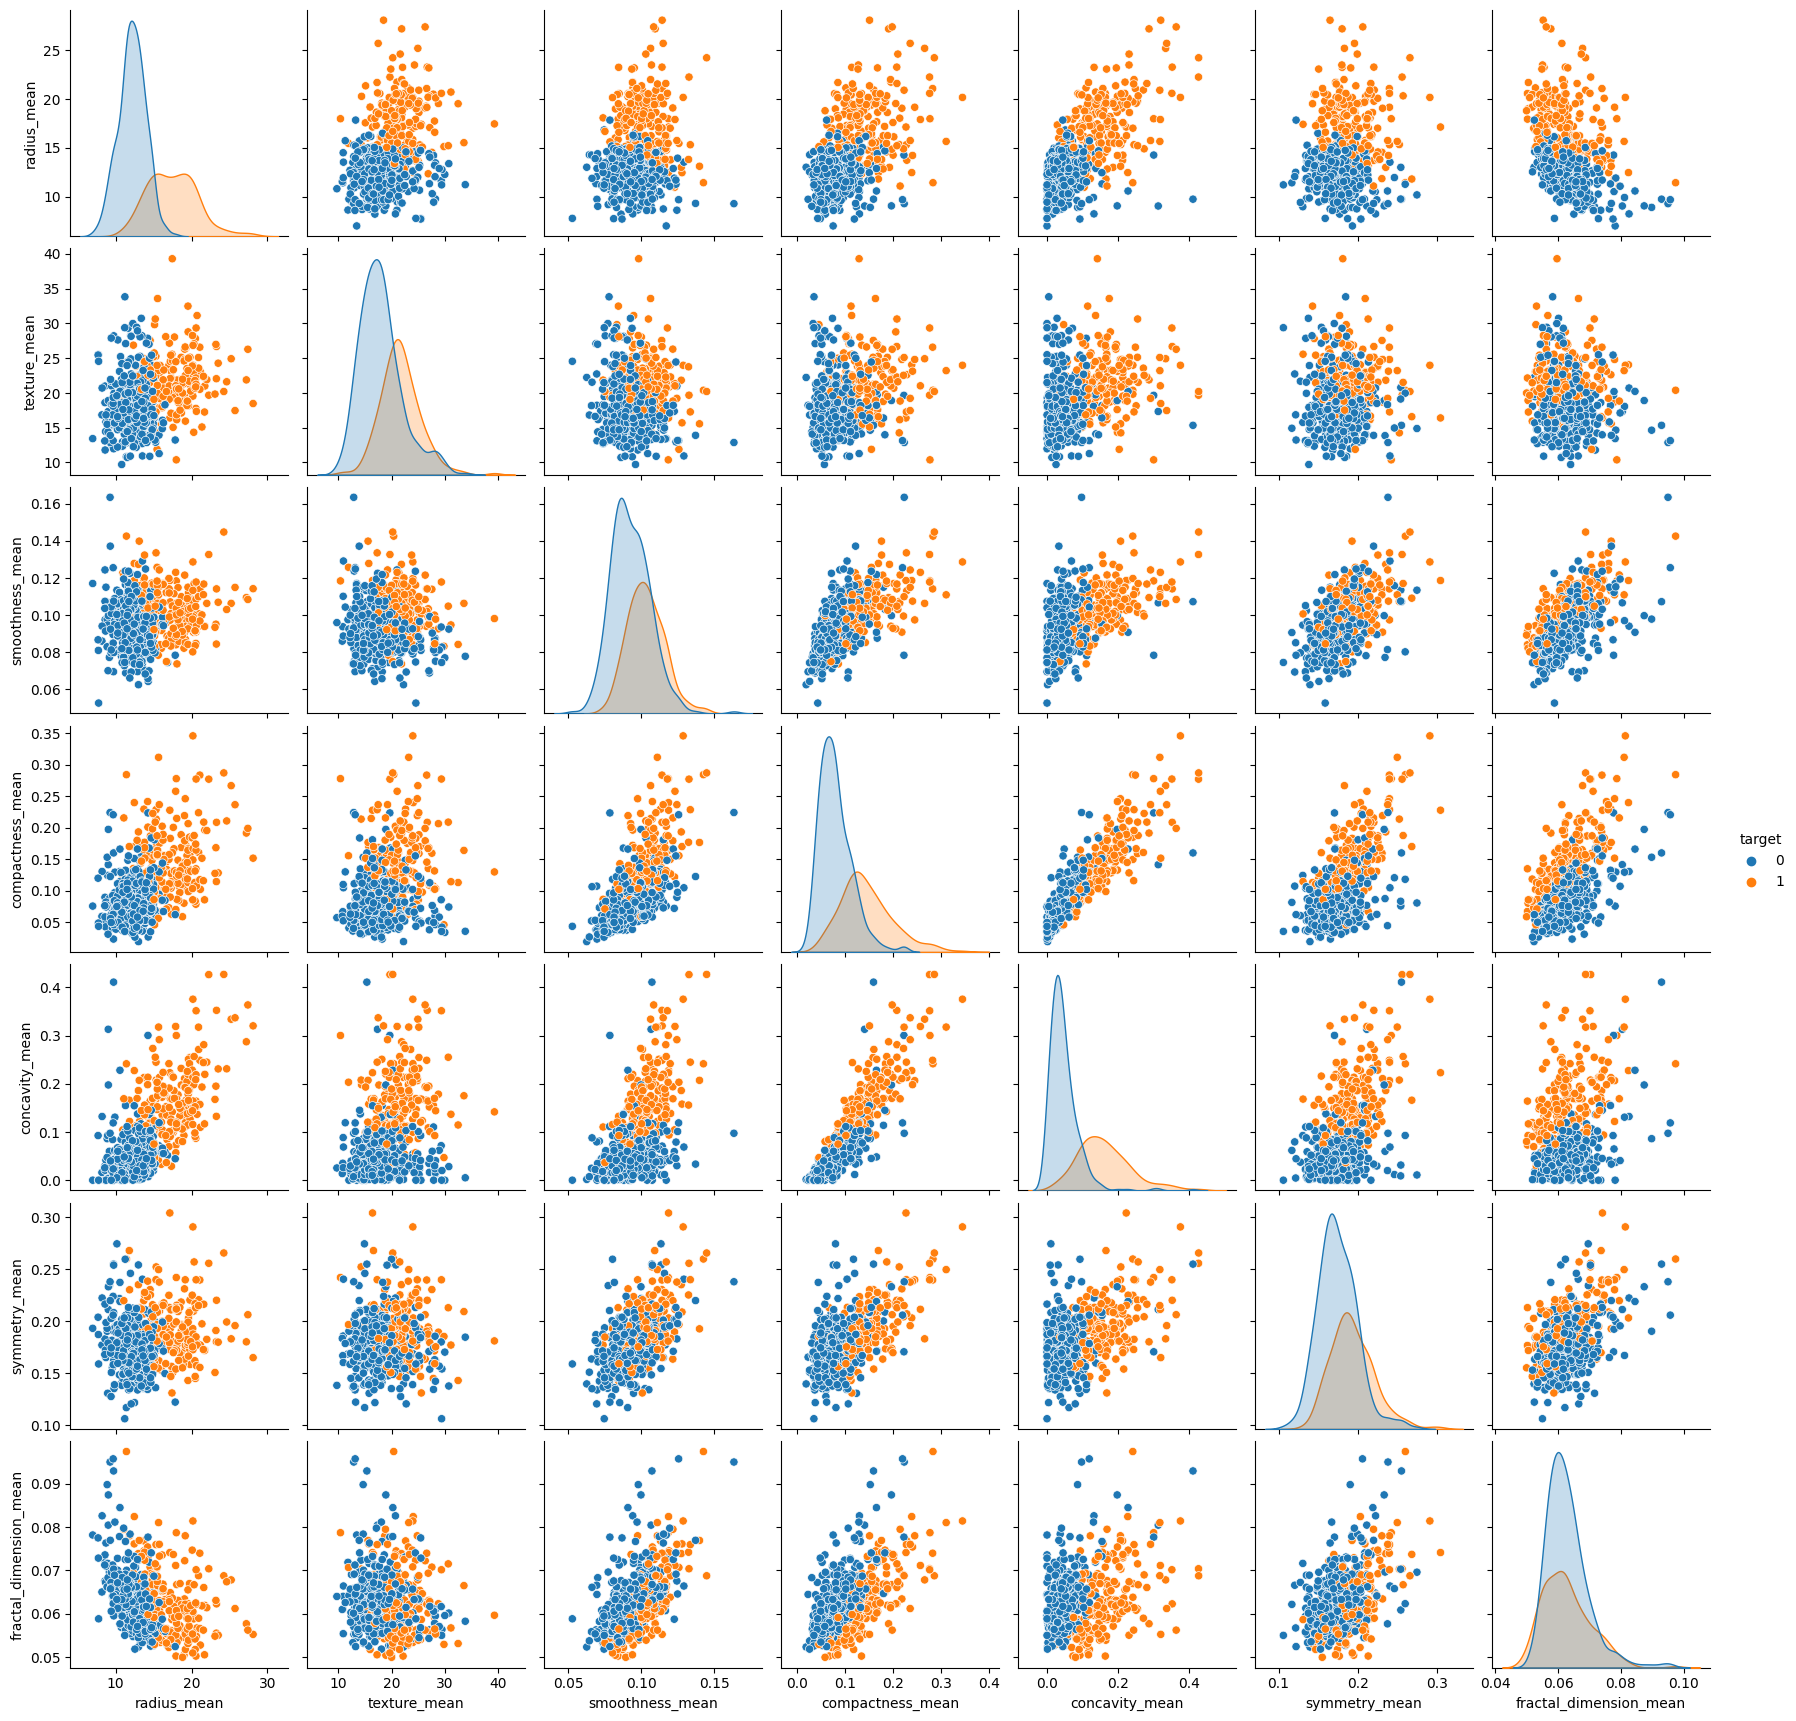

In [8]:
# Plotting the feature pairs, to see the separation of the feature space
df_feature_dropped['target'] = df_breast['diagnosis']

sns.pairplot(df_feature_dropped, vars=features_dropped, hue='target')
plt.show()

# As can be seen from below, the feature space is relatively separated.

In reference to the plot above;
* Each feature pair is plotted, and the scatter plot is coloured by the target label. 
* As can be seen, for most of the feature pairs, the target labels are relatively separated. 
* A relatively separated feature space will help the model getting better performance. 

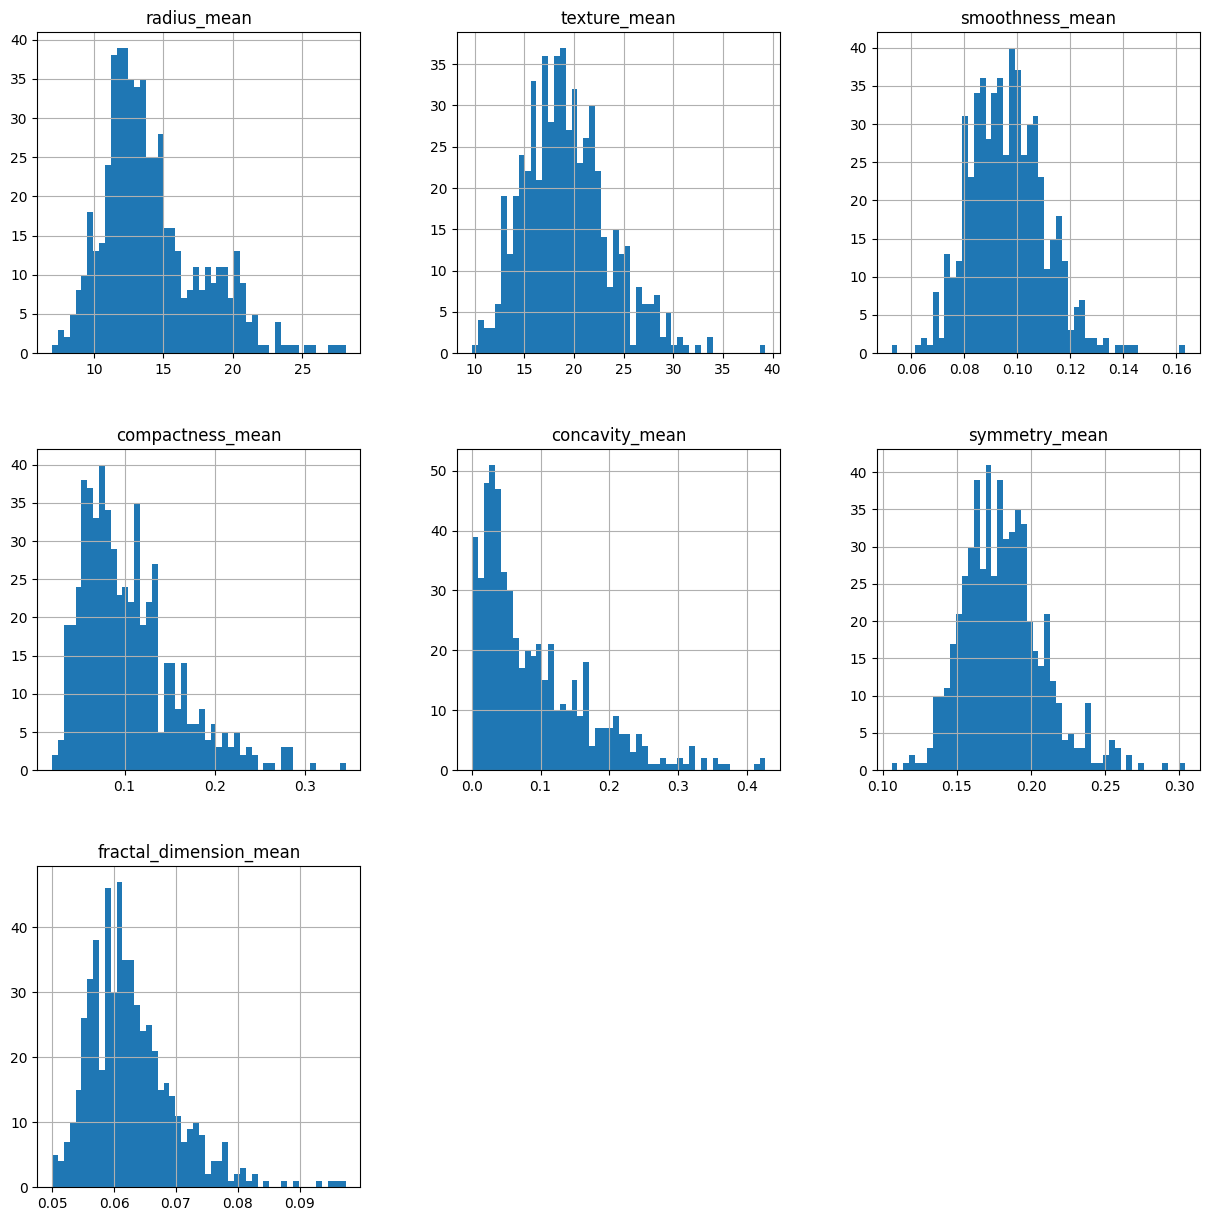

In [9]:
# plotting the distribution of each one of the features
df_feature_dropped[features_dropped].hist(bins=50, figsize=(15,15))
plt.show()

In referece to the above plot:
* The distribution of the 7 features (after dropped) are plotted. 
* Most of the features have a relatively balanced distribution amongst its maximum and minimum values. 
* The concavity feature is slightly right-skewed. 
* slightly right-skewed features may be affecting the model performance, especially the models that rely on presumption of a Gaussian distribution. Resampling techniques can be applied if needed. but we will not be going into this much detailed here. 
* Overall, the rest of the features are quite balanced. 

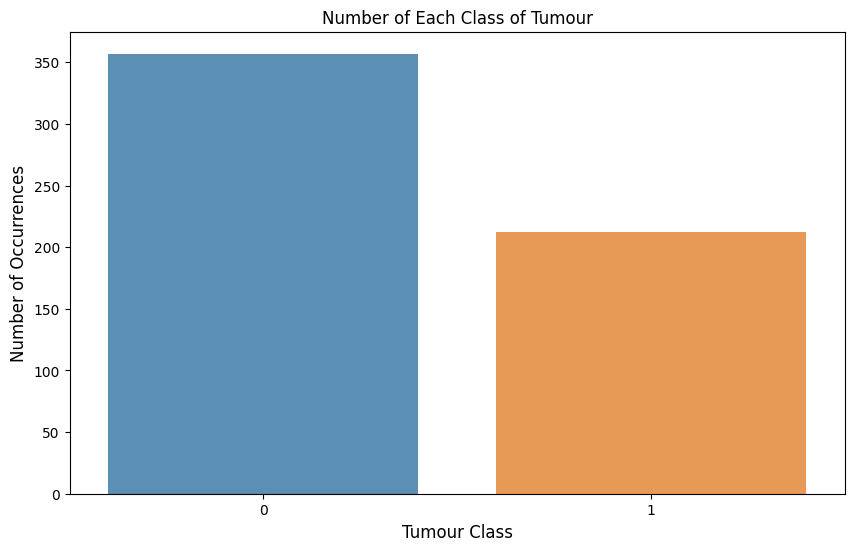

In [10]:
# Count the number of each class
class_counts = df_feature_dropped['target'].value_counts()

plt.figure(figsize=(10,6))
sns.barplot(x=class_counts.index, y=class_counts.values, alpha=0.8)

plt.title('Number of Each Class of Tumour')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Tumour Class', fontsize=12)
plt.show()


In reference to the plot above;
* The class balance of the two classes of tumour is plotted.
* As can be seen, there are a lot more benign than malignant tumours in the dataset. The dataset in inbalanced. 
* There are techniques to split the training and testing set to maintain the same weights for each class in both training and testing set. However, we will not go into too much details here.
* The imbalanced data set will render the "accuracy" metric for model performance less efective. Instead. Precision and recall metrics need to be used to evaluate model performance. 

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Split the dataset 80/20 (typical split by literature)
X = df_feature_dropped.drop(['target'], axis=1)
y = df_feature_dropped['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using standardscaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

##### Part 2: Training the models
* logistic regression and decision tree models
* Grid search
* 5 fold cross validation

Before performing grid search, it is good to think about the scoring strategy in terms of the context of the task:
* The scoring of the hyperparamter should be determined by the task that needs to be performed.
* In this task, we are using the features of the cells to determine if a tumour is benign or malignant. 
* As was shown above, the target space if this dataset is not too balanced, the "accuracy" scoring will not be representative here.
* Some other scoring strategy might be of more relavance here in terms of this binary classification.
* precision -- it checks that out of all the malignant predictions, what portion of tumour is actually malignant. To optimise precision, we are reducing the false positives in the prediction. False positives might have consequence in this context. If a patient having benign tumour is falsely diagnosed as malignant, unnecessary medical procedures might be performed on the patient. 
* recall -- it check that out of all the actual malignant tumours, what portion is identified by the model. Optimising recall reduces the false negatives in the prediction. The consequence of false negative in this context can be: A patient with amlignant tumour is falsely iedntified as benign, no medical intervention is performed in time, allowing the tumour to grow under control. 
* f1 score -- it is the harmonic mean of precision and recall, to best balance precision and recall
* ROC AUC -- The area under the curve for the receiver operating characteristics. It is the integral of recell vs. (1-specificity) for all thresholds for model. 
<br><br>
* In clinic, typically, additional biopsy test will be performed for the identified maligant tumours. So we would like to have a high recall with this initial screening.
* recall will be used as scoring for the grid search.

In [12]:
# training the logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

logistic_params = [
    {
        'solver': ['newton-cg', 'lbfgs', 'sag'], 
        'penalty': ['l2'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'max_iter': [300],
        'random_state':[42]
    },
    {
        'solver': ['liblinear', 'saga'], 
        'penalty': ['l1', 'l2'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'max_iter': [300],
        'random_state':[42]
    },
    {
        'solver': ['saga'], 
        'penalty': ['elasticnet'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],  
        'max_iter': [300],
        'random_state':[42]
    }
]
grid_logistic = GridSearchCV(LogisticRegression(), logistic_params, cv=5, scoring='recall') # 'f1', 'roc_auc', 'recall'

# Train the models
grid_logistic.fit(X_train, y_train)

# Report the best combination of hyperparameters and the corresponding score
print("Best hyperparameters:", grid_logistic.best_params_)
print("Best score:", grid_logistic.best_score_)

# Predict the test set results
y_pred_logistic = grid_logistic.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logistic))
print("\nLogistic Regression Confusion Matrix:\n", confusion_matrix(y_test, y_pred_logistic))
print("\nLogistic Regression Classification Report:\n", classification_report(y_test, y_pred_logistic))

Best hyperparameters: {'C': 100, 'max_iter': 300, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg'}
Best score: 0.8877005347593583
Logistic Regression Accuracy: 0.9649122807017544

Logistic Regression Confusion Matrix:
 [[69  2]
 [ 2 41]]

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97        71
           1       0.95      0.95      0.95        43

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114



In [13]:
# train the decision tree
from sklearn.tree import DecisionTreeClassifier
tree_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 5, 10],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 3, 5, 8],
    'max_features': [None, 'sqrt', 'log2'],
    'random_state':[42]
}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params, cv=5, scoring='recall') # 'f1', 'roc_auc', 'recall'

grid_tree.fit(X_train, y_train)

# Report the best combination of hyperparameters and the corresponding score
print("Best hyperparameters:", grid_tree.best_params_)
print("Best score:", grid_tree.best_score_)

# Predict the test set results
y_pred_tree = grid_tree.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_tree))
print("\nDecision Tree Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tree))
print("\nDecision Tree Classification Report:\n", classification_report(y_test, y_pred_tree))

Best hyperparameters: {'criterion': 'gini', 'max_depth': 2, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42}
Best score: 0.8935828877005347
Decision Tree Accuracy: 0.9473684210526315

Decision Tree Confusion Matrix:
 [[67  4]
 [ 2 41]]

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.94      0.96        71
           1       0.91      0.95      0.93        43

    accuracy                           0.95       114
   macro avg       0.94      0.95      0.94       114
weighted avg       0.95      0.95      0.95       114



* In the above two cell, a logistic regression model and a decision tree model is trained using recall as scoring. 
* Some performance metrics are displayed above. 
* We will discuss the performance of the models in more details using the below visualisations.

##### Part 3: Evaluation and discussion of the model results
* Confusion matrix
* Precision and recall
* ROC & AUC

In [14]:
def plot_confusion(cm, model):
    # Plot Confusion Matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix  -- ' + model)

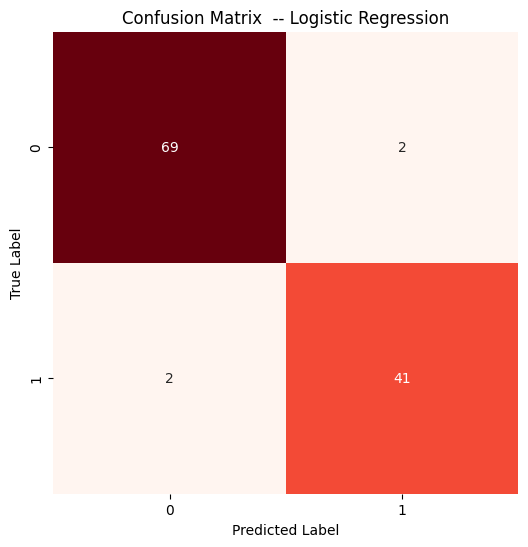

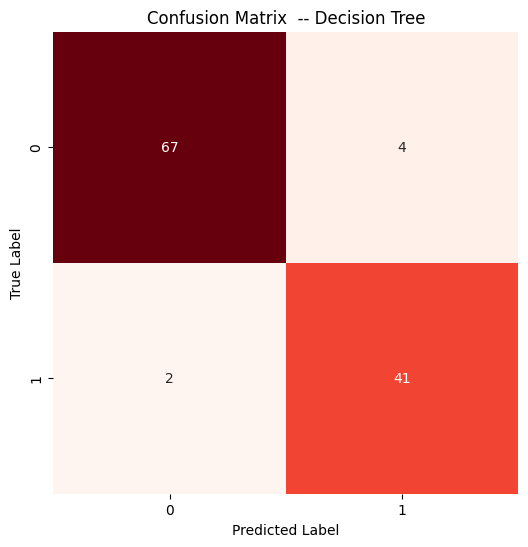

In [15]:
from sklearn.metrics import confusion_matrix
cm_log = confusion_matrix(y_test, y_pred_logistic)
plot_confusion(cm_log, 'Logistic Regression')

cm_tree = confusion_matrix(y_test, y_pred_tree)
plot_confusion(cm_tree, 'Decision Tree')

plt.show()

In reference to the above cell:
* The confusion matrix is plotted for both models. The grid search was performed on "recall" scoring
* As can be seen, the two models have the same recall value 41/(41+2) = 95%
* However, the logistic regression model has better precision 41/(41+2) = 95%, comparing with the desicion tree 41/(41+4)=91%
* The confusion matrix will recommend the logstic regression model in the clinic settings. As there is a good recall rate for the malignant tumours, while logistic regression also has high precision, having less false positives. 

In [16]:
import numpy as np
# Define function to plot Precision, Recall vs, threshold
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    # Get the recall value where precision is above 0.90
    recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
    # Get threshold valie where precision is above 0.90
    threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=10) 
    plt.xlabel("Threshold", fontsize=10)       
    plt.grid(True)                              
    plt.axis([0, 1, 0, 1.1])             

    #plot vertical dash line from precision curve where precision is 0.9
    plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")  

    #plot horizotal dash line from precision curve where precision is 0.9
    plt.plot([-1, threshold_90_precision], [0.9, 0.9], "r:")     

    #plot horisontal line from recall curve where precision is 0.9
    plt.plot([-1, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")

    #plot dot on precision curve where precision is 0.9
    plt.plot([threshold_90_precision], [0.9], "ro")         

    #plot dot on recall curve where precision is 0.9
    plt.plot([threshold_90_precision], [recall_90_precision], "ro")   

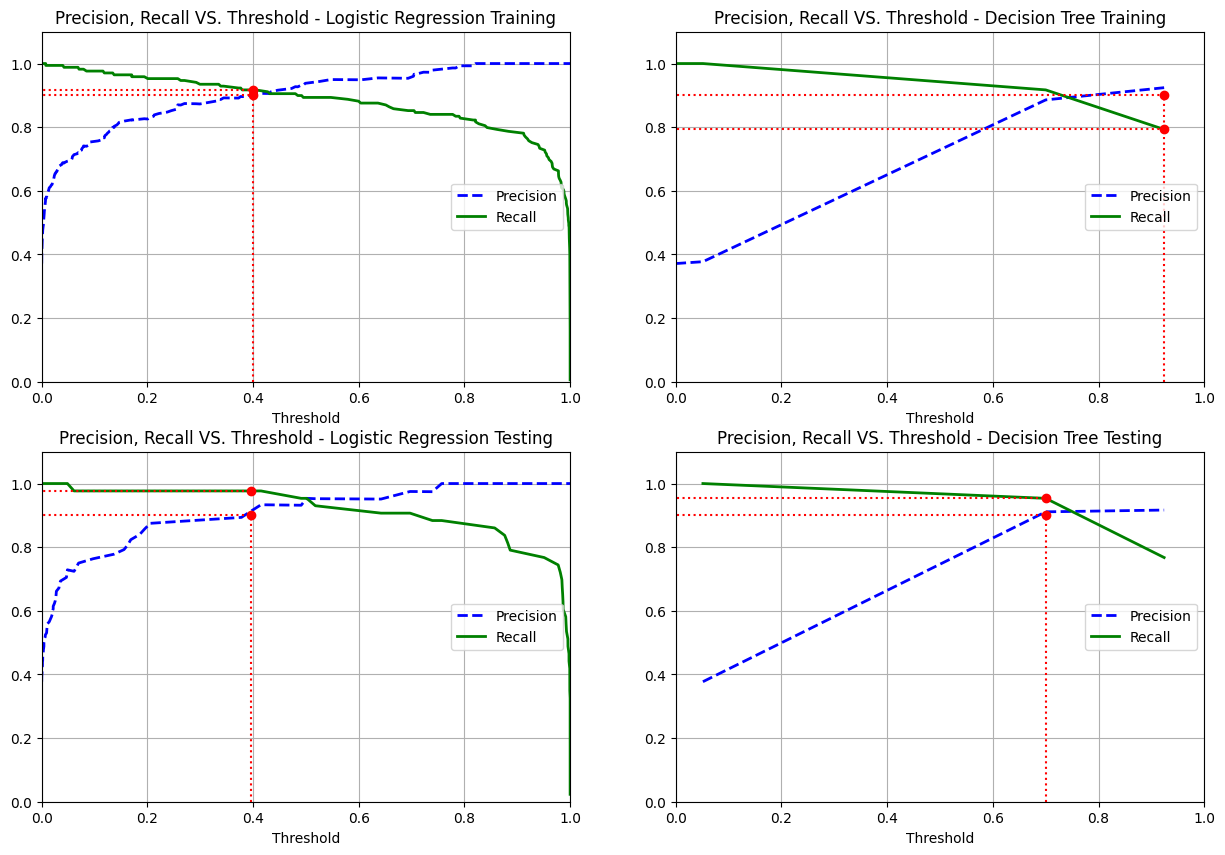

In [17]:
from sklearn.metrics import precision_recall_curve
import numpy as np

plt.figure(figsize=(15, 10)) 
# Calculate precision and recall curve
y_train_prob_log = grid_logistic.predict_proba(X_train)[:, 1]
precisions_train_log, recalls_train_log, thresholds_train_log = precision_recall_curve(y_train, y_train_prob_log)
plt.subplot(2,2,1)
plt.title('Precision, Recall VS. Threshold - Logistic Regression Training')
plot_precision_recall_vs_threshold(precisions_train_log, recalls_train_log, thresholds_train_log)

# Calculate precision and recall curve
y_train_prob_tree = grid_tree.predict_proba(X_train)[:, 1]
precisions_train_tree, recalls_train_tree, thresholds_train_tree = precision_recall_curve(y_train, y_train_prob_tree)
plt.subplot(2,2,2)
plt.title('Precision, Recall VS. Threshold - Decision Tree Training')
plot_precision_recall_vs_threshold(precisions_train_tree, recalls_train_tree, thresholds_train_tree)

# Calculate precision and recall curve
y_test_prob_log = grid_logistic.predict_proba(X_test)[:, 1]
precisions_test_log, recalls_test_log, thresholds_test_log = precision_recall_curve(y_test, y_test_prob_log)
plt.subplot(2,2,3)
plt.title('Precision, Recall VS. Threshold - Logistic Regression Testing')
plot_precision_recall_vs_threshold(precisions_test_log, recalls_test_log, thresholds_test_log)

# Calculate precision and recall curve
y_test_prob_tree = grid_tree.predict_proba(X_test)[:, 1]
precisions_test_tree, recalls_test_tree, thresholds_test_tree = precision_recall_curve(y_test, y_test_prob_tree)
plt.subplot(2,2,4)
plt.title('Precision, Recall VS. Threshold - Decision Tree Testing')
plot_precision_recall_vs_threshold(precisions_test_tree, recalls_test_tree, thresholds_test_tree)


plt.show()

In reference to the cell above:
* The precision and recall are plotted against available thresholds for both training and testing sets. 
* As can be seen, for both models, the precision and recells curves are intersecting close to y = 1, indicating good model performance. 
* The logistic regression model was found to have better performance on the test set than the decision tree (at same recall level, logistic regression has higher precision).
* It is not too easy to tell from the graph above, as the two models have similarly high performance. 
* The below graphs are easier to visualise and help us have a better idea.

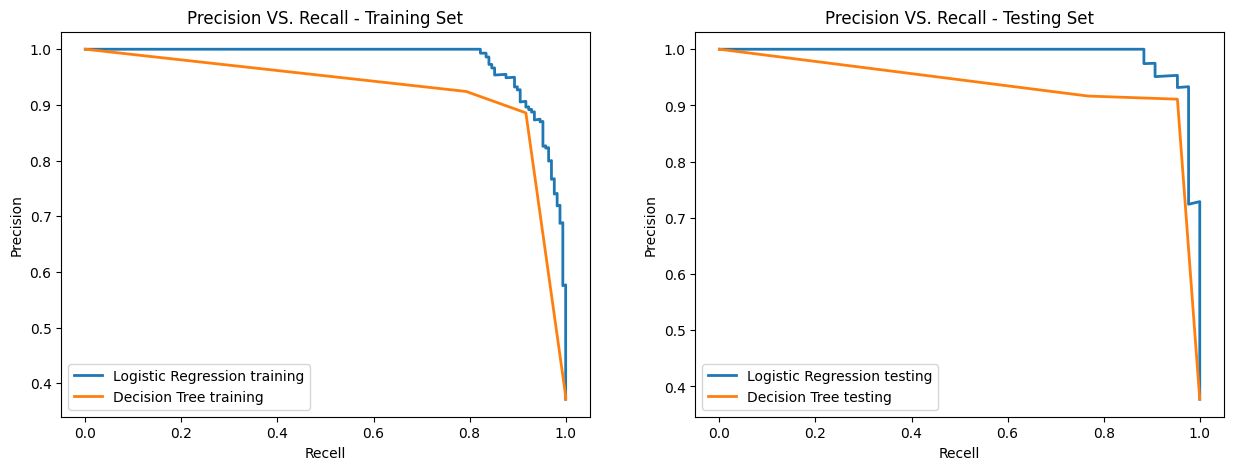

In [18]:
# Plot precision against recall for training & Testing
fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title('Precision VS. Recall - Training Set')
plt.plot(recalls_train_log, precisions_train_log, linewidth=2, label='Logistic Regression training')
plt.plot(recalls_train_tree, precisions_train_tree, linewidth=2, label='Decision Tree training')
plt.xlabel('Recell')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1,2,2)
plt.title('Precision VS. Recall - Testing Set')
plt.plot(recalls_test_log, precisions_test_log, linewidth=2, label='Logistic Regression testing')
plt.plot(recalls_test_tree, precisions_test_tree, linewidth=2, label='Decision Tree testing')
plt.xlabel('Recell')
plt.ylabel('Precision')
plt.legend()

plt.show()

In reference to the above graph:
* Precision and recell are plotted against each other for different thresholds. 
* The closer the curve bends towards (1,1), the better the model performance. 
* As can be seen, for both training and testing set, the logistic regression curve bends more towards (1,1), having better performance than decision tree
* If we draw a vertical line on the graphs, we can see that for the same recall value, the logistic regression model has higher precision.
* Same logic, if we draw a horizontal line, for the same precision value, the logistic regression model has higher recall value. 
* In context of the dataset, we want to be able to identify all the malignant tumours, while not having too many benign tumour falsely identified. The logistic regression model fits the task better.

In [19]:
from sklearn.metrics import auc
def plot_roc(fpr_1, tpr_1, fpr_2, tpr_2, model1, model2):
    plt.plot(fpr_1, tpr_1, linewidth=2, label=model1 + ' train (area = %0.2f)' % auc(fpr_1, tpr_1))
    plt.plot(fpr_2, tpr_2, linewidth=2, label=model2 + ' test (area = %0.2f)' % auc(fpr_2, tpr_2))

    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([-0.1, 1, 0, 1.1])                                    
    plt.xlabel('False Positive Rate (Fall-Out/1-Specificity)', fontsize=12) 
    plt.ylabel('True Positive Rate (Sensitivity/Recall)', fontsize=12) 
    plt.grid(True)  
    plt.legend()

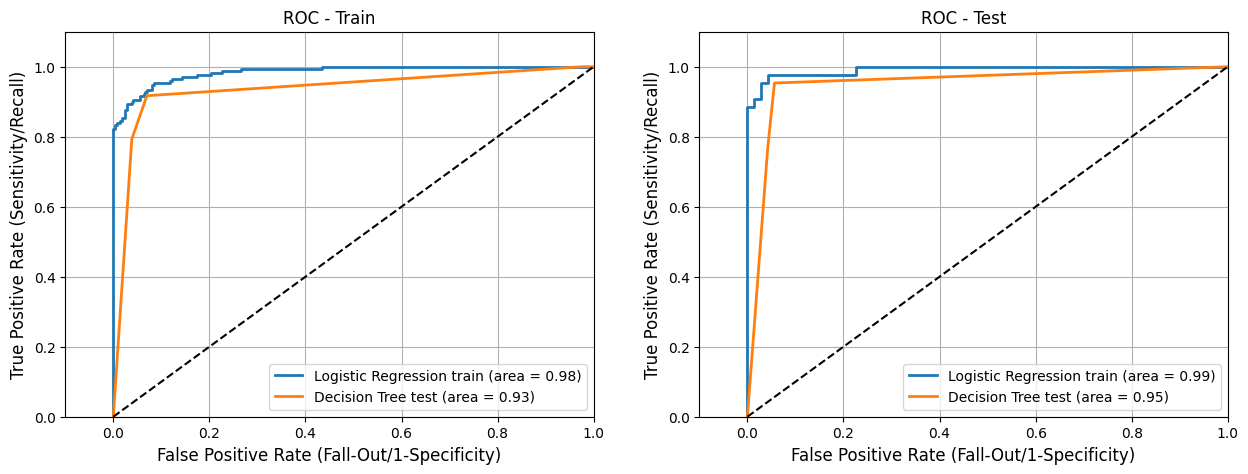

In [20]:
# Plot ROC for training & Testing
from sklearn.metrics import roc_curve

fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
y_train_prob_log = grid_logistic.predict_proba(X_train)[:, 1]
fpr_train_log, tpr_train_log, thresholds_train_log = roc_curve(y_train, y_train_prob_log)

y_train_prob_tree = grid_tree.predict_proba(X_train)[:, 1]
fpr_train_tree, tpr_train_tree, thresholds_train_tree = roc_curve(y_train, y_train_prob_tree)
plt.title('ROC - Train')
plot_roc(fpr_train_log, tpr_train_log, fpr_train_tree, tpr_train_tree, 'Logistic Regression', 'Decision Tree')

plt.subplot(1,2,2)
y_test_prob_log = grid_logistic.predict_proba(X_test)[:, 1]
fpr_test_log, tpr_test_log, thresholds_test_log = roc_curve(y_test, y_test_prob_log)

y_test_prob_tree = grid_tree.predict_proba(X_test)[:, 1]
fpr_test_tree, tpr_test_tree, thresholds_test_tree = roc_curve(y_test, y_test_prob_tree)
plt.title('ROC - Test')
plot_roc(fpr_test_log, tpr_test_log, fpr_test_tree, tpr_test_tree, 'Logistic Regression', 'Decision Tree')

plt.show()

In reference to the cell above:
* The ROC curve is plotted for both boths and both training and teating set
* The AUC is calculated for each ROC curve
* As can be seen, for both training and testing set, the logistic regression model bends more towards (0,1), indicating better performance. This is the same, confirming the above visualisations
* The calculated AUC is also higher for logistic regression for both training and testing set.
* It confirms all the metrics above -- that the logistic regression is better fit for this task -- tumour labelling.

### Task 2: Feature importance from the above models

In [21]:
best_logistic = grid_logistic.best_estimator_
best_tree = grid_tree.best_estimator_

# Get coefficients for logistic regression
logistic_coefs = best_logistic.coef_[0]

# Get feature importances for decision tree
tree_importances = best_tree.feature_importances_

In [22]:
import numpy as np

feature_names = np.array([i.split('_')[0] for i in features_dropped])

# Sort features by logistic regression coefficients
sorted_idx_logistic = np.argsort(np.abs(logistic_coefs))[::-1]
sorted_features_logistic = feature_names[sorted_idx_logistic]

# Sort features by decision tree importances
sorted_idx_tree = np.argsort(tree_importances)[::-1]
sorted_features_tree = feature_names[sorted_idx_tree]

print("Feature importance ranking for Logistic Regression:")
print(sorted_features_logistic)

print("\nFeature importance ranking for Decision Tree:")
print(sorted_features_tree)


Feature importance ranking for Logistic Regression:
['radius' 'concavity' 'smoothness' 'texture' 'compactness' 'symmetry'
 'fractal']

Feature importance ranking for Decision Tree:
['concavity' 'radius' 'fractal' 'symmetry' 'compactness' 'smoothness'
 'texture']


The above two cells calculated and ranked the feature importance for the two models respectively. To better visualise the feature importance, the below graphs are plotted.

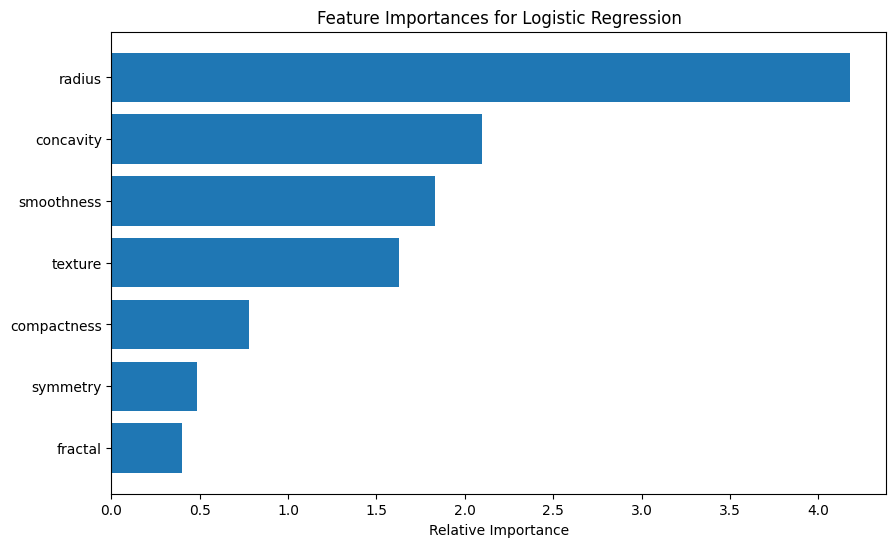

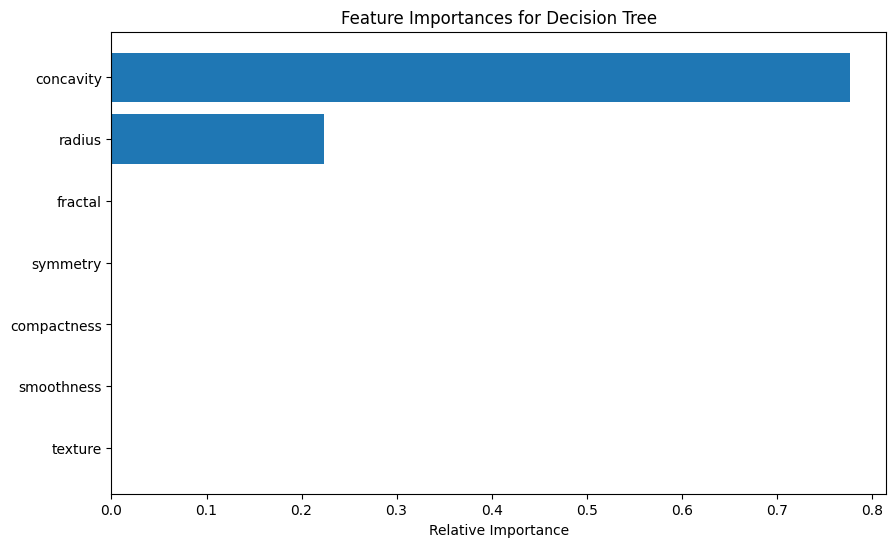

In [23]:
# Function for the feature importance bar plot
def plot_feature_importances(importances, feature_names, model_name):
    indices = np.argsort(importances)
    plt.figure(figsize=(10, 6))
    plt.title(f'Feature Importances for {model_name}')
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

# Plot for Logistic Regression
# Convert coefficients to positive values to denote importance
plot_feature_importances(np.abs(best_logistic.coef_[0]), feature_names, 'Logistic Regression')

# Plot for Decision Tree
plot_feature_importances(best_tree.feature_importances_, feature_names, 'Decision Tree')


In reference to the feature importance plot above:
* All features are used in logistic regression to identify the status of the tumour
* Only two features are used in decision tree
* The two features -- Concavity and radius, used in decision tree are the highest importances features by logistic regression. 
* Logistic regression considers radius feature to be of higher importance in identifying the status of the tumour, while decision tree identified concavity to be of higher importance in identifying tumour status. 
* Overall, the radius feature and the concavity feature are better at classifiying the status of the tumour according to the two models. The two models put higher importance to each of the two features respectively. 

### Task 3, 4, 5: PCA implementation, and interpretation

In [24]:
from sklearn.decomposition import PCA

# For PCA, no train test plit is used here, and all data are scaled. 
sd_scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit PCA with 2 components
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_scaled)

# Create a DataFrame with the principal components
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, df_breast[['diagnosis_text']]], axis=1)


In [25]:
# Print explained variance
print('Explained variance by first 2 principal components: {:.2%}'.format(sum(pca.explained_variance_ratio_)))

Explained variance by first 2 principal components: 74.07%


In [26]:
df_pca_vectors = pd.DataFrame(columns=['feature_name','PC1','PC2'])
for i in range(pca.components_.shape[1]):
    df_pca_vectors.loc[len(df_pca_vectors)] = [feature_names[i],
                                               pca.components_[0, i]*np.sqrt(pca.explained_variance_[0]),
                                               pca.components_[1, i]*np.sqrt(pca.explained_variance_[1])]
df_pca_vectors

,feature_name,PC1,PC2
0,radius,0.492100,-0.780503
1,texture,0.258412,-0.578169
2,smoothness,0.772792,0.337228
3,compactness,0.955444,-0.051326
4,concavity,0.891884,-0.306116
5,symmetry,0.732944,0.257333
6,fractal,0.589962,0.688744


The above is the principle component of the features for tumour status identification. We will now plot the instances in the dataset using the first 2 principle components and label by the tumour status, along with the arrows for each features -- biplot. 

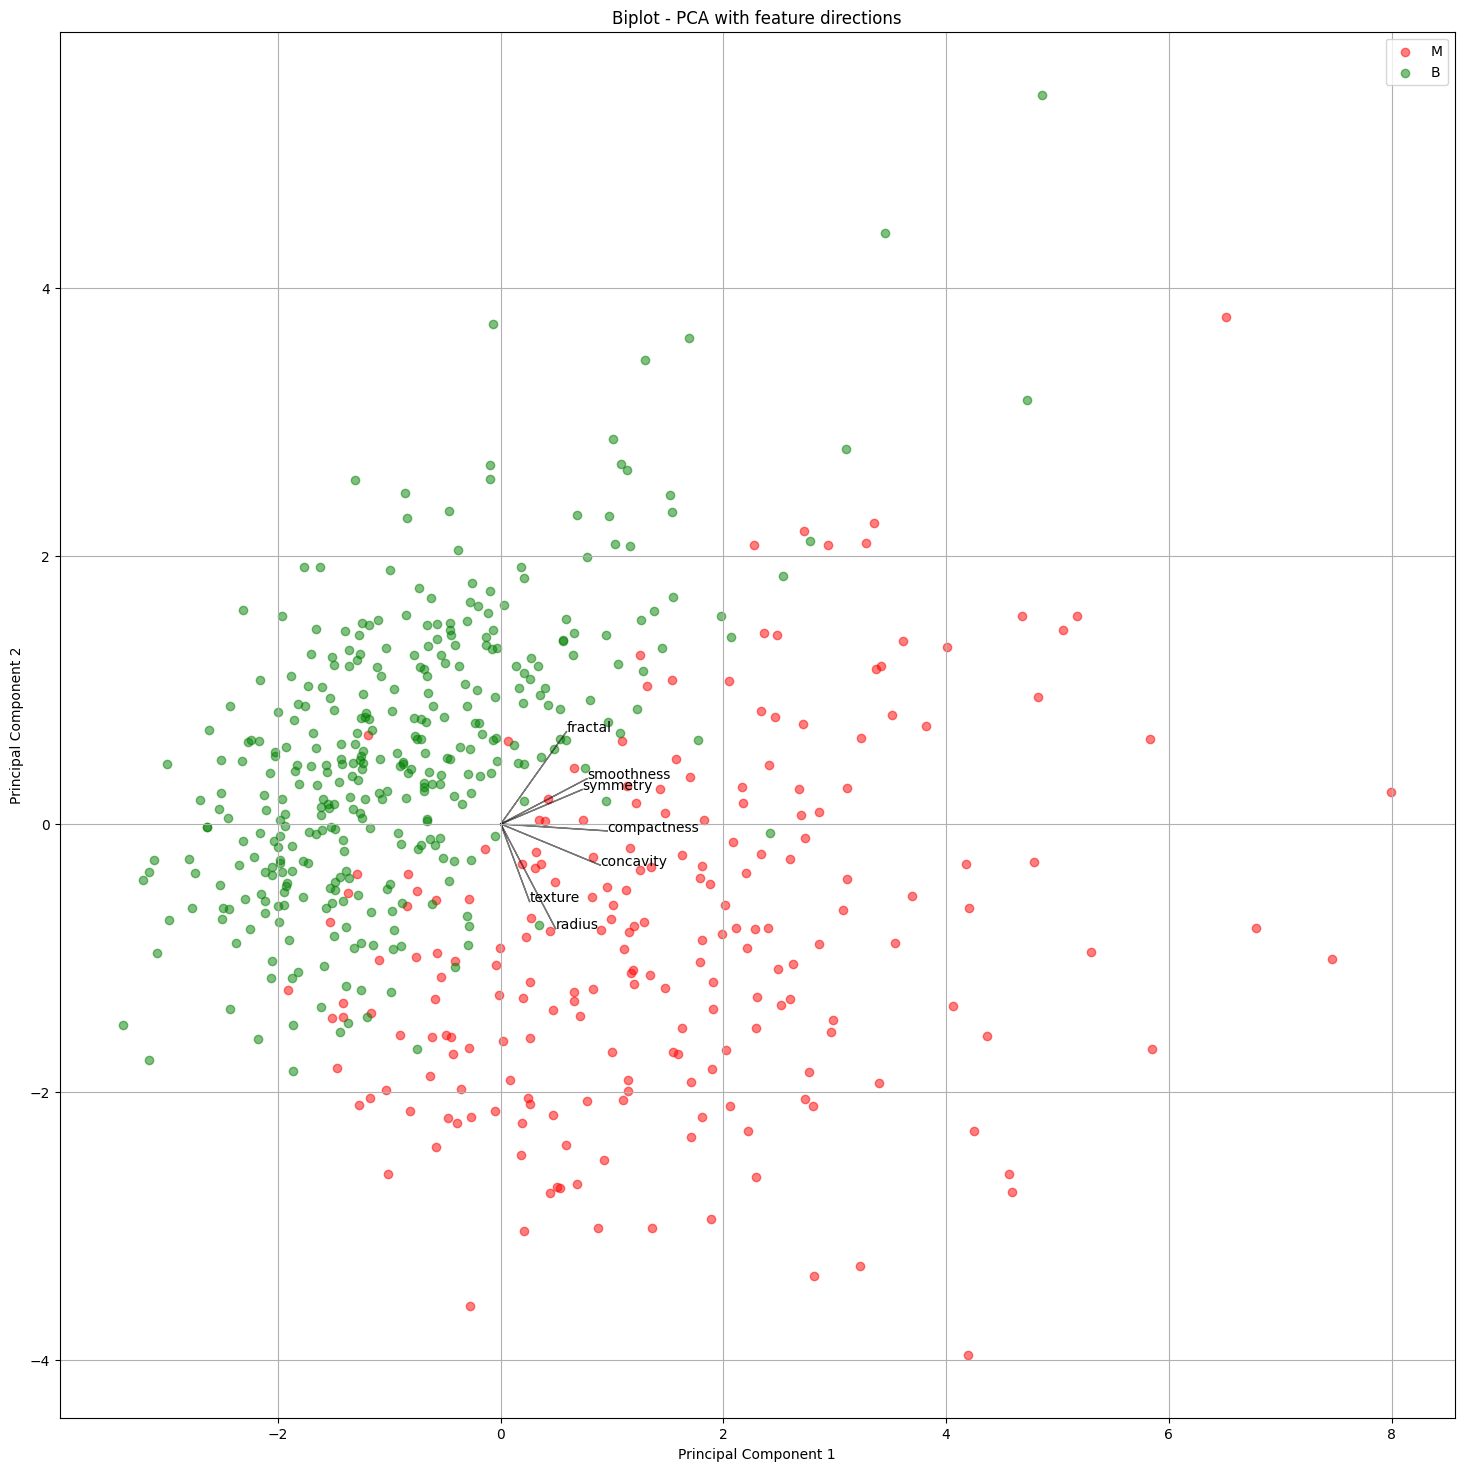

In [27]:
fig, ax = plt.subplots(figsize=(18, 18))

# Plot data
# scatter = ax.scatter(principalComponents[:, 0], principalComponents[:, 1], alpha=0.5)

targets = ['M', 'B']
colors = ['r', 'g']
for target, color in zip(targets, colors):
    indicesToKeep = finalDf['diagnosis_text'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1'],
               finalDf.loc[indicesToKeep, 'principal component 2'],
               c=color,
               alpha=0.5)

# Plot arrows for each feature
for i in range(pca.components_.shape[1]):
    plt.arrow(0, 0, pca.components_[0, i]*np.sqrt(pca.explained_variance_[0]), pca.components_[1, i]*np.sqrt(pca.explained_variance_[1]), color='black',alpha=0.5)
    plt.text(pca.components_[0, i]*np.sqrt(pca.explained_variance_[0]), pca.components_[1, i]*np.sqrt(pca.explained_variance_[1]), feature_names[i])
    

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Biplot - PCA with feature directions')
plt.legend(targets)
plt.grid()
plt.show()


In reference to the plot above:
* The above is the Biplot of the PCA using first 2 principle components.
* Each point in the plot is an instance of the dataset on the principle componant axis. The instance are labelled by the status of the tumour, green being benign and red being malignant. 
* The arrorws are the directions of the features with respect to the principle components. The direction of the arrow indicates the feature correlation with the two principle components. The length of the arrow indicates the strength of the features correlation to the principle components. 
* The projection of the datapoints onto the feature arrows indicates the datapoint's value with respect to the feature. 
The angles between arrows means how closely each feature correlates with each other. Small angles mean high correlation between features (like smoothness and symmetry). Right angles mean the features are uncorrelated (Smoothness/symmetry and texture/radius).
* In this dataset, as can be seen, the benign tumours and malignant tumours are quite separated by the first two principle components. The benign points are majorly around the top left corner of the axes and the malignant tumours are majorly around the bottom right corner of the axes. 
* A good feature that can separate the benign and malignant tumours should have direction crossing from top left to bottom right or the other way around. 
* As can be seen from the plot, the concavity feature visuallly has the best direction that crosses the two target spaces, separating the benign and malignant tumours. The radius and compactness feature have relatively good direction that has the potential to help separate the tumour status. 
* On the other hand, the fractal feature is almost parallel to the target space, it means that it is not good with separating the tumour statuses.
* Here to also note that the two principle component explained 74% variance. Although it is not too low, there are still 26%  variance that is not represented in this plot. <br><br>
* The PCA biplot agrees with the feature importance calculated by logistic regression and decision tree. Concavity and radius has the highest importance and fractal has the lowest importance.

### Task 6: Repeat the logistic regression and random forrest using >95% PCA and compare results
* Considering the data leakeage issue, PCA cannot be performed on the entire dataset in the beginning. Instead, the following steps are followed: <br><br>
* Split the data into a training set and a test set.
* Scale the features of the training set. Compute the PCA on the training set
* Apply the same scaling and PCA transformation learned from the training set to the test set.
* Train the logistic regression model again
* Compare results

In [28]:
X_train, X_test, y_train_pca, y_test_pca = train_test_split(X, y, test_size=0.2, random_state=42)
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 

# Perform PCA
pca_95 = PCA(n_components=0.95)  
X_train_pca = pca_95.fit_transform(X_train_scaled)
X_test_pca = pca_95.transform(X_test_scaled) 

# Print the number of components
print("Number of components to retain 95% variance: ", pca_95.n_components_)

Number of components to retain 95% variance:  5


In [29]:
from sklearn.metrics import roc_auc_score
param_grid = [
    {
        'solver': ['newton-cg', 'lbfgs', 'sag'], 
        'penalty': ['l2'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'max_iter': [300],
        'random_state':[42]
    },
    {
        'solver': ['liblinear', 'saga'], 
        'penalty': ['l1', 'l2'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'max_iter': [300],
        'random_state':[42]
    },
    {
        'solver': ['saga'], 
        'penalty': ['elasticnet'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],  
        'max_iter': [300],
        'random_state':[42]
    }
]

# Initiate Logistic Regression model
logistic_pca = LogisticRegression()

# Grid search
clf_pca = GridSearchCV(logistic_pca, param_grid, cv=5, scoring='recall')

# Fit model with the PCA-transformed data
clf_pca.fit(X_train_pca, y_train_pca)

# Report the best combination of hyperparameters and the corresponding score
print("Best hyperparameters:", clf_pca.best_params_)
print("Best score:", clf_pca.best_score_)

# Predict the test set results
y_pred_pca = clf_pca.predict(X_test_pca)

# Print AUC score
auc_score_pca = roc_auc_score(y_test_pca, clf_pca.predict_proba(X_test_pca)[:, 1])
print("AUC Score with PCA features: ", auc_score_pca)

print("Logistic Regression Accuracy:", accuracy_score(y_test_pca, y_pred_pca))
print("\nLogistic Regression Confusion Matrix:\n", confusion_matrix(y_test_pca, y_pred_pca))
print("\nLogistic Regression Classification Report:\n", classification_report(y_test_pca, y_pred_pca))

Best hyperparameters: {'C': 1, 'max_iter': 300, 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear'}
Best score: 0.8934046345811051
AUC Score with PCA features:  0.9937766131673764
Logistic Regression Accuracy: 0.9736842105263158

Logistic Regression Confusion Matrix:
 [[70  1]
 [ 2 41]]

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98        71
           1       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



In the above cell:
* The same grid search on the same large hyperparameter space is performed using the 5 principle components.
* The best hyperparameters found for PCA is a bit different from Raw data, C value from 100 to 1, penalty from l2 to l1, and solver from newton-cg to liblinear. 
* The best score of the grid search is higher than the logistic regression trained on raw data, and also higher accuracy.
* We will use the below plots to visualise the confusion matrix and precision recall. But from the numbers, PCA is doing slightly better than raw data, classified one additional instance correctly. 

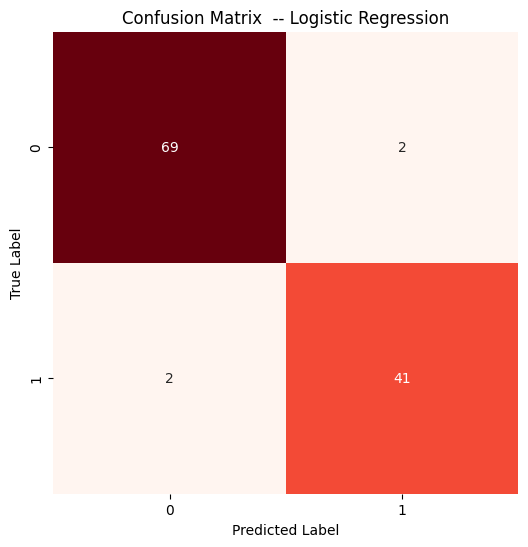

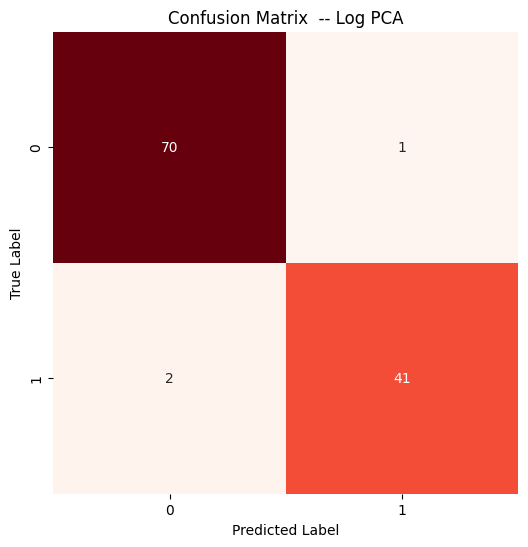

In [30]:
from sklearn.metrics import confusion_matrix
cm_log = confusion_matrix(y_test, y_pred_logistic)
plot_confusion(cm_log, 'Logistic Regression')

cm_pca = confusion_matrix(y_test_pca, y_pred_pca)
plot_confusion(cm_pca, 'Log PCA')

plt.show()

The above is the visualisation of the confusion matrix:
* As can be seen, the logistic regression trained in PCA has one less false positive -- beging tumour wrongly labelled malignant. 
* The logistic regression trained on pca is slightly better than raw data -- the PCA model has slighly better precision in identifying the tumour status, but same recall. 

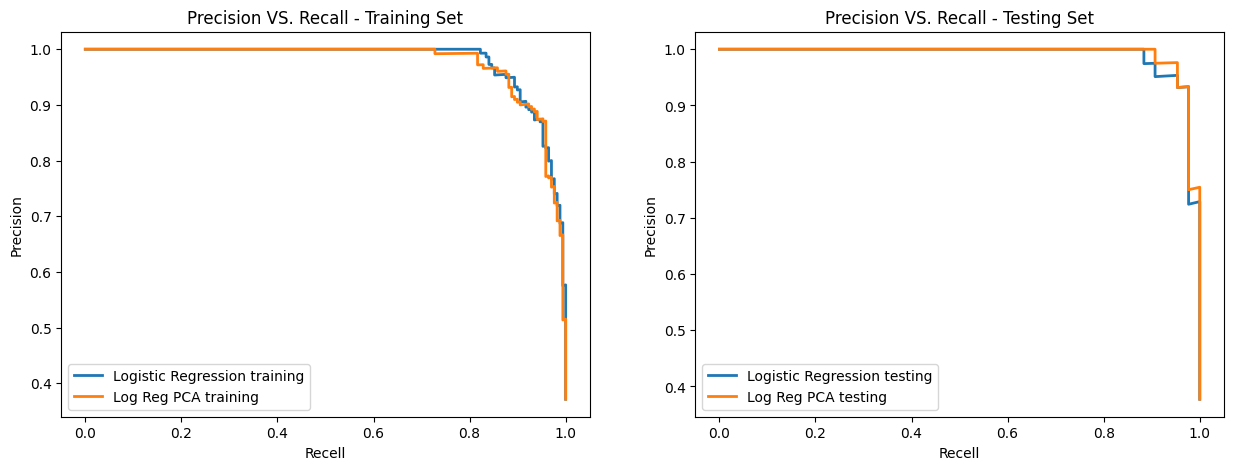

In [31]:
y_train_prob_pca = clf_pca.predict_proba(X_train_pca)[:, 1]
precisions_train_pca, recalls_train_pca, thresholds_train_pca = precision_recall_curve(y_train_pca, y_train_prob_pca)

y_test_prob_pca = clf_pca.predict_proba(X_test_pca)[:, 1]
precisions_test_pca, recalls_test_pca, thresholds_test_pca = precision_recall_curve(y_test_pca, y_test_prob_pca)

# Plot precision against recall for training & Testing
fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title('Precision VS. Recall - Training Set')
plt.plot(recalls_train_log, precisions_train_log, linewidth=2, label='Logistic Regression training')
plt.plot(recalls_train_pca, precisions_train_pca, linewidth=2, label='Log Reg PCA training')
plt.xlabel('Recell')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1,2,2)
plt.title('Precision VS. Recall - Testing Set')
plt.plot(recalls_test_log, precisions_test_log, linewidth=2, label='Logistic Regression testing')
plt.plot(recalls_test_pca, precisions_test_pca, linewidth=2, label='Log Reg PCA testing')
plt.xlabel('Recell')
plt.ylabel('Precision')
plt.legend()

plt.show()

The above is the precision & recall curve:
* For both training and testing set of the two logistic regression models trained on raw data and PCA.
* For the training set, raw data and PCA have similar performance. The two models are both best models from grid search. They are doing similarly well on the training set.
* From before, we know that the PCA result correctly labeled one more test set instance. Therefore, as can be seen, the curve for PCA is slightly better for the test set -- the PCA model has slighly better precision in identifying the tumour status, but same recall. 

# Section 2: A clustering analysis on airlines safety records <br>

### Task 1: K-means clustering (k=2 - k=8)

In [32]:
df_airline = pd.read_csv('airline-safety.csv')

In [33]:
df_airline.head()

,airline,avail_seat_km_per_week,incidents_85_99,fatal_accidents_85_99,fatalities_85_99,incidents_00_14,fatal_accidents_00_14,fatalities_00_14
0,Aer Lingus,320906734,2,0,0,0,0,0
1,Aeroflot*,1197672318,76,14,128,6,1,88
2,Aerolineas Argentinas,385803648,6,0,0,1,0,0
3,Aeromexico*,596871813,3,1,64,5,0,0
4,Air Canada,1865253802,2,0,0,2,0,0


In [34]:
# To see the total number of missing values in the entire DataFrame
total_missing_values = df_airline.iloc[:,1:].isna().sum().sum()
print(f"\nTotal missing values in DataFrame: {total_missing_values}")


Total missing values in DataFrame: 0


In [35]:
# Divide other features by 'avail_seat_km_per_week' to calculated the safety event percentage -- Rate
columns_to_normalize = ['incidents_85_99', 'fatal_accidents_85_99', 'fatalities_85_99', 
                        'incidents_00_14', 'fatal_accidents_00_14', 'fatalities_00_14']

for col in columns_to_normalize:
    df_airline[col] = df_airline[col] / df_airline['avail_seat_km_per_week']

# Show the modified dataframe
df_airline.head()

,airline,avail_seat_km_per_week,incidents_85_99,fatal_accidents_85_99,fatalities_85_99,incidents_00_14,fatal_accidents_00_14,fatalities_00_14
0,Aer Lingus,320906734,6.232340e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,Aeroflot*,1197672318,6.345642e-08,1.168934e-08,1.068740e-07,5.009718e-09,8.349529e-10,7.347586e-08
2,Aerolineas Argentinas,385803648,1.555195e-08,0.000000e+00,0.000000e+00,2.591992e-09,0.000000e+00,0.000000e+00
3,Aeromexico*,596871813,5.026205e-09,1.675402e-09,1.072257e-07,8.377008e-09,0.000000e+00,0.000000e+00
4,Air Canada,1865253802,1.072240e-09,0.000000e+00,0.000000e+00,1.072240e-09,0.000000e+00,0.000000e+00


In [36]:
from sklearn.preprocessing import StandardScaler
# scale the entire feature space -- 6 features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_airline.iloc[:,2:])

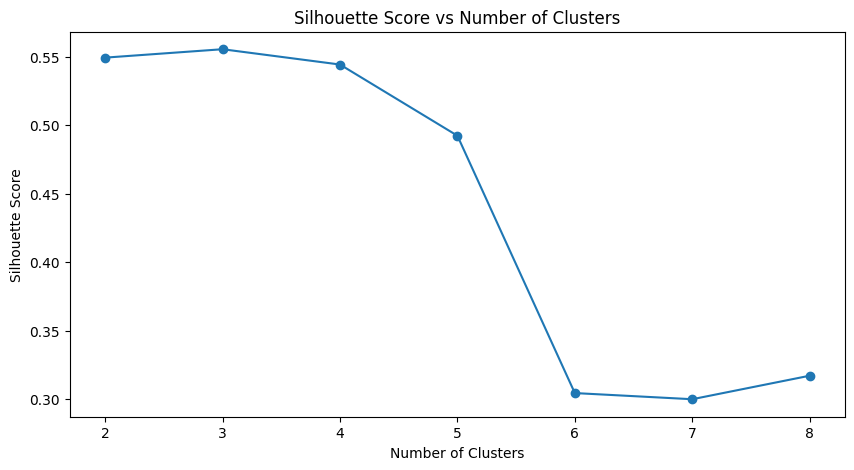

In [37]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

scores = []
range_values = range(2,9)

# applying K mean clustering to the entire feature space
for i in range_values:
    kmeans = KMeans(n_clusters=i, n_init=10, random_state=5508)
    kmeans.fit(data_scaled)
    score = silhouette_score(data_scaled, kmeans.labels_)
    scores.append(score)

plt.figure(figsize=(10,5))
plt.plot(range_values, scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.show()

In reference to the above cell:
* The silhouette score is a measurement of how a datapoint is similar to the its cluster, compare with the other clusters. It ranges from -1 to 1. the higher the score, the better matched with the cluster a datapoint is.
* If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.
* The best K to use is usually the one that gives the highest silhouette score. In this case, 3.
* Here to note that silhouette score tends to favor convex clusters over other concepts of clusters, such as chain-like clusters or clusters of clusters.
* Here we will still take k = 3.

### Task 2: K- mean clustering with k = 3 and discussions

Explained variance by first 2 principal components: 73.76%


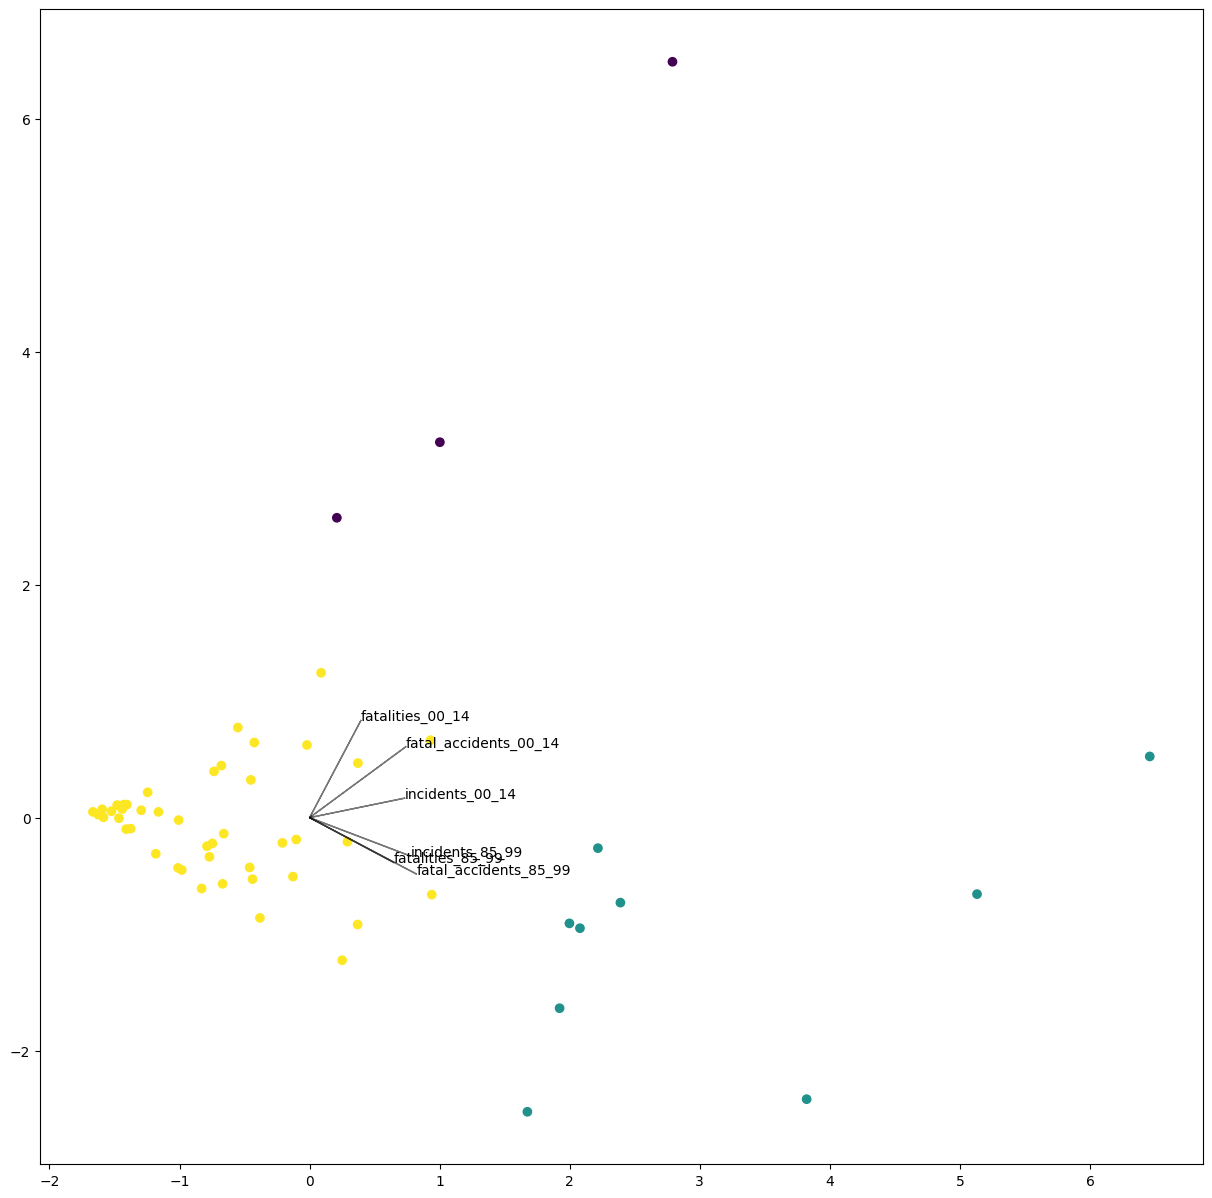

In [38]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Perform K-means clustering
kmeans = KMeans(n_clusters=3, n_init = 10, random_state=5508)
kmeans.fit(data_scaled)

# Perform PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

# Print explained variance
print('Explained variance by first 2 principal components: {:.2%}'.format(sum(pca.explained_variance_ratio_)))

plt.figure(figsize=(15,15))

# Plot the data
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=kmeans.labels_)

# arrows for each feature
features = df_airline.columns[2:]
for i, feature in enumerate(features):
    plt.arrow(0, 0, pca.components_[0, i]*np.sqrt(pca.explained_variance_[0]), pca.components_[1, i]*np.sqrt(pca.explained_variance_[1]), color='black',alpha=0.5)
    plt.text(pca.components_[0, i]*np.sqrt(pca.explained_variance_[0]), pca.components_[1, i]*np.sqrt(pca.explained_variance_[1]), feature)
plt.show()

For the plot above:
* As all 6 features are used for clustering, we cannot plot all 6 features together, therefore, the first two principle components are used. And the direction of each feature on the first two principle component is plotted.
* The clustering is modeled on safety event rate, and the feature space is scaled. 
* Before any explanations, the first two principle component is only explaining 74% of the variance, it is not ideal. We will use other plots to evaluate later on. 
* On the first two principle components, the data are separated into three clear clusters.
* All the features are plotted with their direction with respect to the first two PCs. 
* All features are positively correlated with the first principle component to different extend. 
* The 00-14 features are positively correlated with the second principle component, while the 85-99 features are negatively correlated with the second PC. 
* All the features are safety event rate. Higher value in these features means higher safety events rate -- that the airline is less safe. 
* It can be seen that the first principle component is describing the overall safety level, and the second principle component is describing the difference between 00-14 and 85-99. 
* As can be seen, the clustering has separated the airlines into three main categories -- relatively safe at all times (in yellow -- on the left, and little spread on the second PC, meaning relatively safe across the years), high safety event rate from 00 to 14 (purple -- on the top right, alignes with the direction of the 00-14 components), and high safety event rate from  85 to 99 (green -- on the bottom right, aligns with the direction of the 85-99 commponents). 
* To understand it better, the below plot is produced.

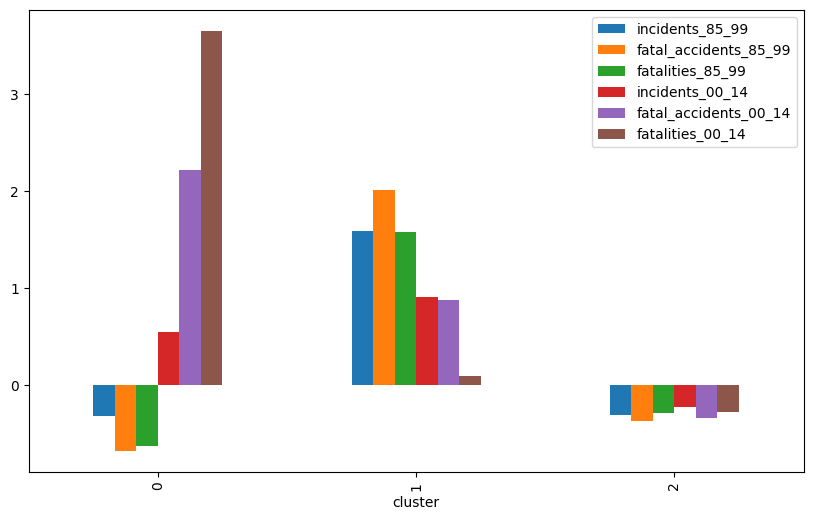

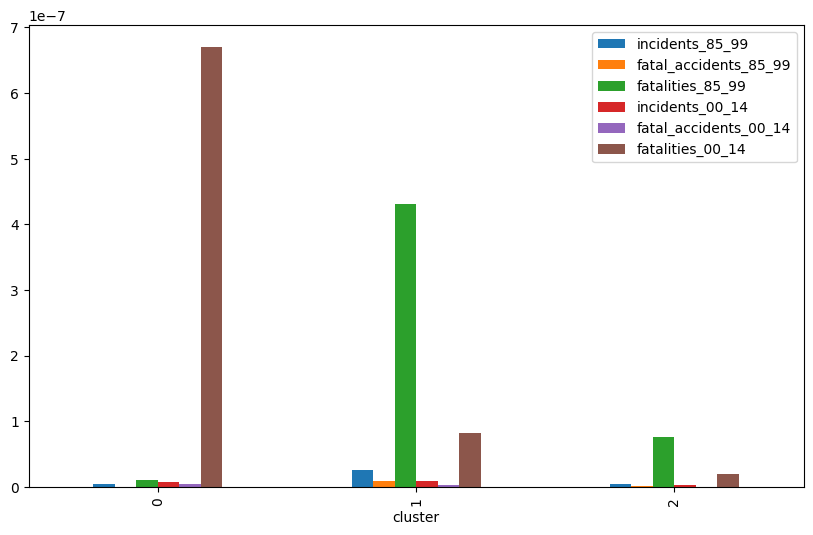

In [39]:
# Convert to DataFrame
df_data_scaled = pd.DataFrame(data_scaled, columns=df_airline.columns[2:]) 
df_data = df_airline.iloc[:,2:]

# Add cluster labels
df_data_scaled['cluster'] = kmeans.labels_
df_data['cluster'] = kmeans.labels_

# Compute cluster profiles
profiles_scaled = df_data_scaled.groupby('cluster').mean()
profiles = df_data.groupby('cluster').mean()

# Plot each profile
profiles_scaled.plot(kind='bar', figsize=(10, 6))
profiles.plot(kind='bar', figsize=(10, 6))
plt.show()

The cell above is plotting the mean values for each features for each cluster. 
* The first graph is plotting using the scaled feature value (also what the K-mean is fit on). The second graph is plotting the mean of the raw data for each cluster. 
* As can be seen, cluster 0 has high number of safety event rate for 00-14, while relatively low safety event rate for 85-99. Cluster 1 has high number of safety events rate for 85-99, and medium level of safety event rate for 00-14. and cluster 2 represents the safer airlines with low safety event rate for both 85-99 and 00-14. 
* This confirms the interpretation of the previous biplot. <br><br>

* Here to note that the raw "unscaled" data is still calculated by dividing the "available seat kilometres flown every week", so it should be interpreted as the rate of safety event. 

### Task 3: Discussions on scaling and feature space selection

**Scaling:**

Scaling is an important step in preparing data for machine learning algorithms, including K-means. K-means compares the distance between points to see how similar they are. If the variables have different scales (meaning they range in different values), the ones with larger scales can have a bigger influence on the distance calculation. This can cause problems and lead to incorrect clustering.

In this case, we first divided the safety record by the flight volume to adjust for the ratio of safety event, so that the flight volume feature is left out in the clustering analysis. 

To address this issue, we use standard scaler before applying K-means clustering. Standard scaling adjusts the variables so that they are on a similar scale. This ensures that all the variables, like incident, fatality incident, and fatality number, are considered equally important for the clustering process.

In some cases, depending on the specific task or application, we might want certain features with larger scales to have a greater impact on the clustering. However, in this particular case, we have chosen to scale the data using the standard scaler to ensure all the variables have similar importance for the clustering analysis.

**Using All Variables:**

The decision on whether to use all variables or just a few depends on whatia required and what the application is.

In the case of analyzing airline safety data, if we want to take into account all aspects of airline safety, such as incidents, fatal accidents, fatalities, with respect to the flight volume, for both timeframes (85 to 99 and 00 to 14), then it's best to use all the variables. This way, we can get a complete picture of airline safety.

However, there may be situations where certain variables aren't relevant or could create unnecessary confusion. For example, if we are only interested in fatal accidents, then the variable for 'incidents' may not be as important and can be left out. Also, if we are only interested in the airline safety in the recent years, the records for 85 - 99 can be left out. 

Additionally, some variables might be closely related to each other (multicollinearity), which can affect how well certain algorithms perform. In those cases, we might consider leaving out those variables. In this particular case, all the variables seem to be important for analyzing airline safety, and there don't appear to be any issues with variables being highly correlated. So, it would make sense to include all the variables in the analysis. However, it's always a good idea to carefully examine the data and consider the analysis goals when deciding which variables to include.

### Task 4: K-means cluster analysis on 1985-1999 and 2000-2014 separately

In [40]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

data_85_99 = df_airline[['incidents_85_99', 'fatal_accidents_85_99', 'fatalities_85_99']].copy()
data_00_14 = df_airline[['incidents_00_14', 'fatal_accidents_00_14', 'fatalities_00_14']].copy()

# Scale the data
scaler_85_99 = StandardScaler()
data_85_99_scaled = scaler_85_99.fit_transform(data_85_99)
scaler_00_14 = StandardScaler()
data_00_14_scaled = scaler_00_14.fit_transform(data_00_14)

# Apply K-means with k=3
kmeans_85_99 = KMeans(n_clusters=3, n_init = 10, random_state=5508).fit(data_85_99_scaled)
kmeans_00_14 = KMeans(n_clusters=3, n_init = 10, random_state=5508).fit(data_00_14_scaled)

data_85_99['cluster'] = kmeans_85_99.labels_
data_00_14['cluster'] = kmeans_00_14.labels_


Since the feature space is completely different for the three models, we will not be comparing the model performane (like inertia). Instead, the application of the clustering and the meaning of the clustering will be compard using the plots below. 

In [41]:
from sklearn.decomposition import PCA

# Define a function to plot PCA scatter plot
def plot_pca_scatter(data, kmeans_model, title, features):
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(data)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
    principalDf['Cluster'] = kmeans_model.labels_

    # fig = plt.figure(figsize = (8,8))
    # ax = fig.add_subplot(1,1,1) 
    plt.xlabel('Principal Component 1', fontsize = 6)
    plt.ylabel('Principal Component 2', fontsize = 6)
    plt.title(title, fontsize = 10)

    targets = list(set(kmeans_model.labels_))
    colors = ['r', 'g', 'b']
    for target, color in zip(targets,colors):
        indicesToKeep = principalDf['Cluster'] == target
        plt.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
                   , principalDf.loc[indicesToKeep, 'principal component 2']
                   , c = color
                   , s = 10)
    # arrows for each feature
    for i, feature in enumerate(features):
        plt.arrow(0, 0, pca.components_[0, i]*np.sqrt(pca.explained_variance_[0]), pca.components_[1, i]*np.sqrt(pca.explained_variance_[1]), color='black',alpha=0.5)
        plt.text(pca.components_[0, i]*np.sqrt(pca.explained_variance_[0]), pca.components_[1, i]*np.sqrt(pca.explained_variance_[1]), feature)

    plt.legend(targets)
    plt.grid()

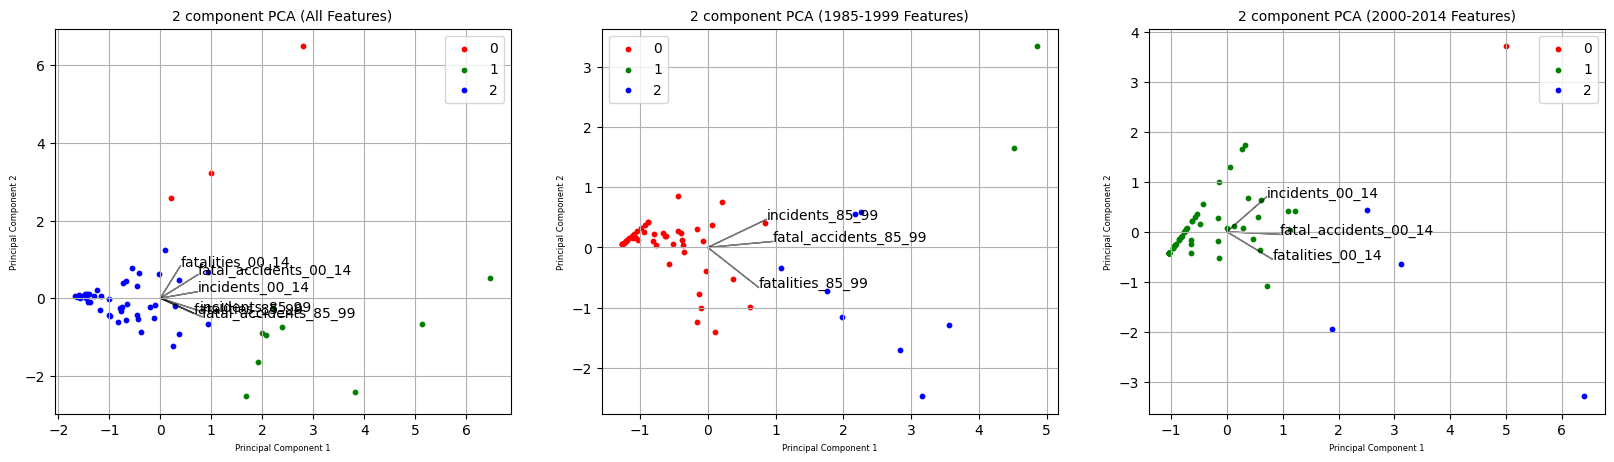

In [42]:
plt.figure(figsize=(20, 5)) 

plt.subplot(1,3,1)
plot_pca_scatter(data_scaled, kmeans, '2 component PCA (All Features)', df_airline.columns[2:])
plt.subplot(1,3,2)
plot_pca_scatter(data_85_99_scaled, kmeans_85_99, '2 component PCA (1985-1999 Features)', data_85_99.columns[:-1])
plt.subplot(1,3,3)
plot_pca_scatter(data_00_14_scaled, kmeans_00_14, '2 component PCA (2000-2014 Features)', data_00_14.columns[:-1])


For the above plot:
* The PCA biplot is plotted for the two new models using only 85-99 safety record and 00-14 safety records.
* The first clustering using all features separated the airlines into -- Overall safe, unsafe during 85-99, and unsafe during 00-14.
* The second clustering using only features from 85-99 separated the airlines into -- overall safe during 85-99, medium safety events rate during 85-99, and high safety events rate during 85-99.
* The third clustering using only features from 00-14 separated the airlines into -- overall safe during 00-14, medium safety events rate during 00-14, and high safety events rate during 00-14
* We will not go into the details of the biplots here. Please refer to the previous comments.
<br><br>
* The the application of the clustering is completely different when the selection of the feature space is different. 

In [43]:
def plot_biplot_only(kmeans_model, title, features, principalDf):
    principalDf['Cluster'] = kmeans_model.labels_

    plt.xlabel('Principal Component 1', fontsize = 6)
    plt.ylabel('Principal Component 2', fontsize = 6)
    plt.title(title, fontsize = 10)

    targets = list(set(kmeans_model.labels_))
    colors = ['r', 'g', 'b']
    for target, color in zip(targets,colors):
        indicesToKeep = principalDf['Cluster'] == target
        plt.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
                    , principalDf.loc[indicesToKeep, 'principal component 2']
                    , c = color
                    , s = 10)
    # # arrows for each feature
    # for i, feature in enumerate(features):
    #     plt.arrow(0, 0, pca.components_[0, i]*np.sqrt(pca.explained_variance_[0]), pca.components_[1, i]*np.sqrt(pca.explained_variance_[1]), color='black',alpha=0.5)
    #     plt.text(pca.components_[0, i]*np.sqrt(pca.explained_variance_[0]), pca.components_[1, i]*np.sqrt(pca.explained_variance_[1]), feature)

    plt.legend(targets)
    plt.grid()

The below is another biplot to have the three models all plotted on the priciple components of all 6 scaled features, so that it is easier to visualise how the clustering for the entire dataset is changed spatially. 

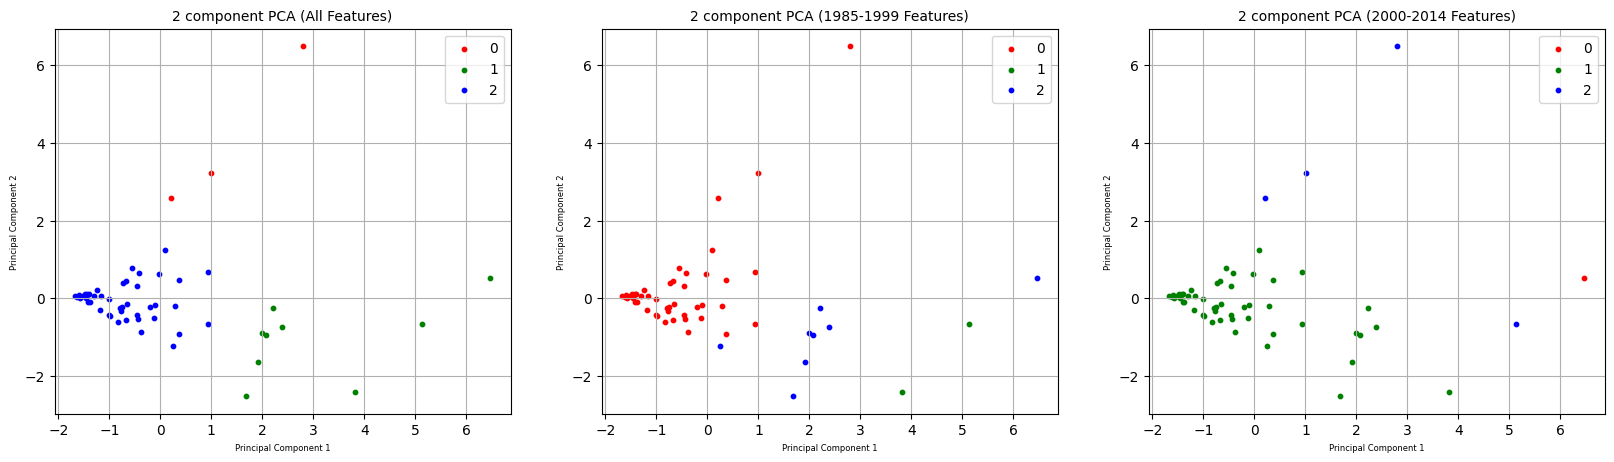

In [44]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(data_scaled)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

plt.figure(figsize=(20, 5)) 

plt.subplot(1,3,1)
plot_biplot_only(kmeans, '2 component PCA (All Features)', df_airline.columns[2:], principalDf)
plt.subplot(1,3,2)
plot_biplot_only(kmeans_85_99, '2 component PCA (1985-1999 Features)',  df_airline.columns[2:], principalDf)
plt.subplot(1,3,3)
plot_biplot_only(kmeans_00_14, '2 component PCA (2000-2014 Features)',  df_airline.columns[2:], principalDf)

* The above is the three models all plotted on the principle component of the 6 features, although the last two models are only using three of the six features. 
* As can be seen, the grouping of the data instances is completely different. For more details please refer to the previous plot. 

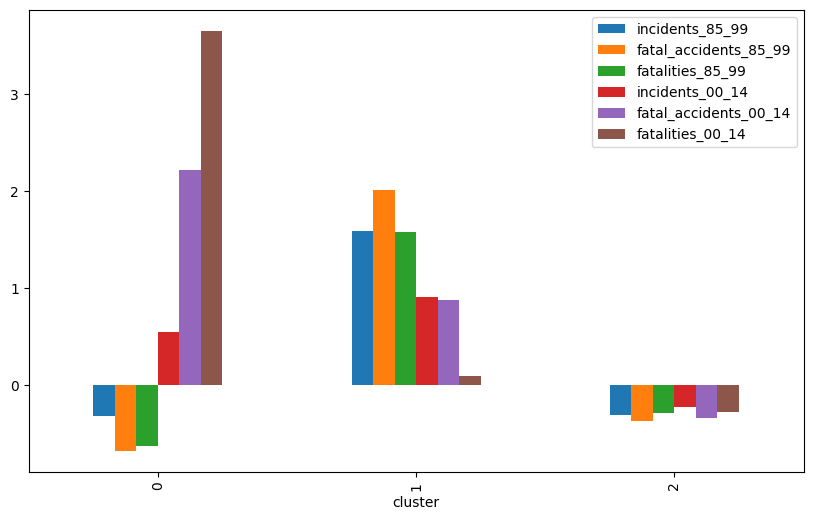

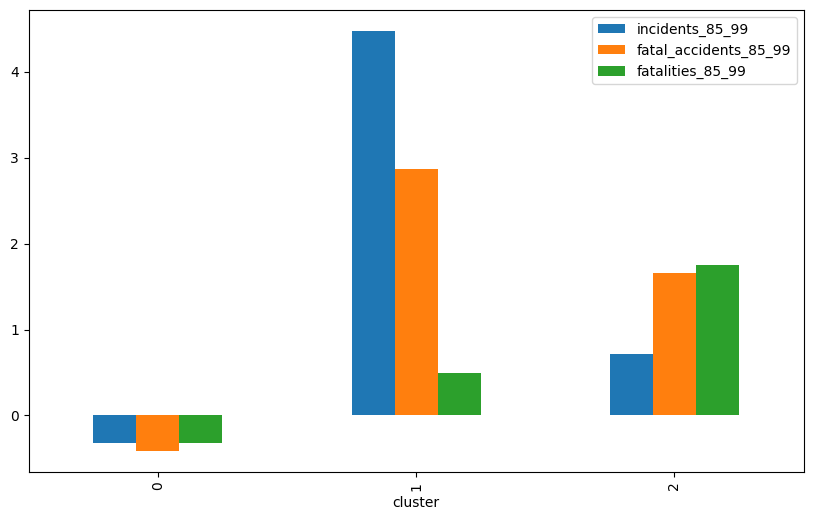

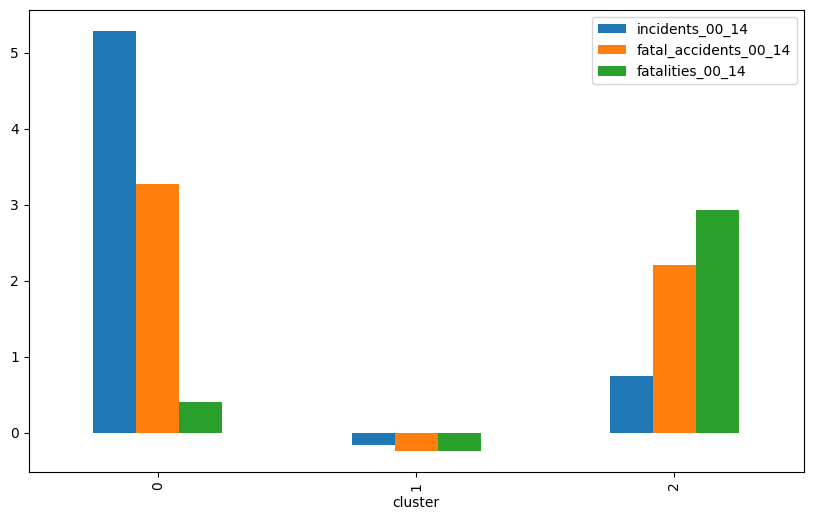

In [45]:
df_data_85_99_scaled = pd.DataFrame(data_85_99_scaled, columns=data_85_99.columns[:-1])
df_data_85_99_scaled['cluster'] = kmeans_85_99.labels_

df_data_00_14_scaled = pd.DataFrame(data_00_14_scaled, columns=data_00_14.columns[:-1])
df_data_00_14_scaled['cluster'] = kmeans_00_14.labels_

# Compute cluster profiles
profiles_scaled = df_data_scaled.groupby('cluster').mean()
profiles_85_99 = df_data_85_99_scaled.groupby('cluster').mean()
profiles_00_14 = df_data_00_14_scaled.groupby('cluster').mean()

# Plot each profile
profiles_scaled.plot(kind='bar', figsize=(10, 6))
profiles_85_99.plot(kind='bar', figsize=(10, 6))
profiles_00_14.plot(kind='bar', figsize=(10, 6))

plt.show()

The mean values of the scaled features are calculated for each cluster and plotted:
* As mentioned before, the first clustering using all features separated the airlines into -- Overall safe, unsafe during 85-99, and unsafe during 00-14. We will not go into details here again. 
* As can be seen, for the second model using only 85-99 features, cluster 1 has lowest safety event rate during 85-99 -- they are the safe airlines during 85-99, cluster 0 has slighter higher safety events rate during 85-99, meaning their safety level is a bit more concerning during 85-99, cluster 2 has the highest rate of the safety event during 85-99, being the most unsafe during 85-99. 
* Note that the second clustering has no information on the safety level during 00 and 14.
* As can be seen, for the third model using only 00-14 features, cluster 2 has lowest safety event rate during 00-14 -- they are the safe airlines during 00-14, cluster 0 has slighter higher safety events rate during 00-14, meaning their safety level is a bit more concerning during 00-14, cluster 2 has the highest rate of the safety event during 00-14, being the most unsafe during 00-14. 
* Note that the third clustering has no information on safety level during 85 and 99.
* Depend on the application and the goal, different feature space should be used. 

In [46]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

def silhouette_plot(data, kmeans_model, title):
    cluster_labels = kmeans_model.labels_
    n_clusters = len(set(cluster_labels))

    silhouette_avg = silhouette_score(data, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  

    plt.title("The silhouette plot for " + title)

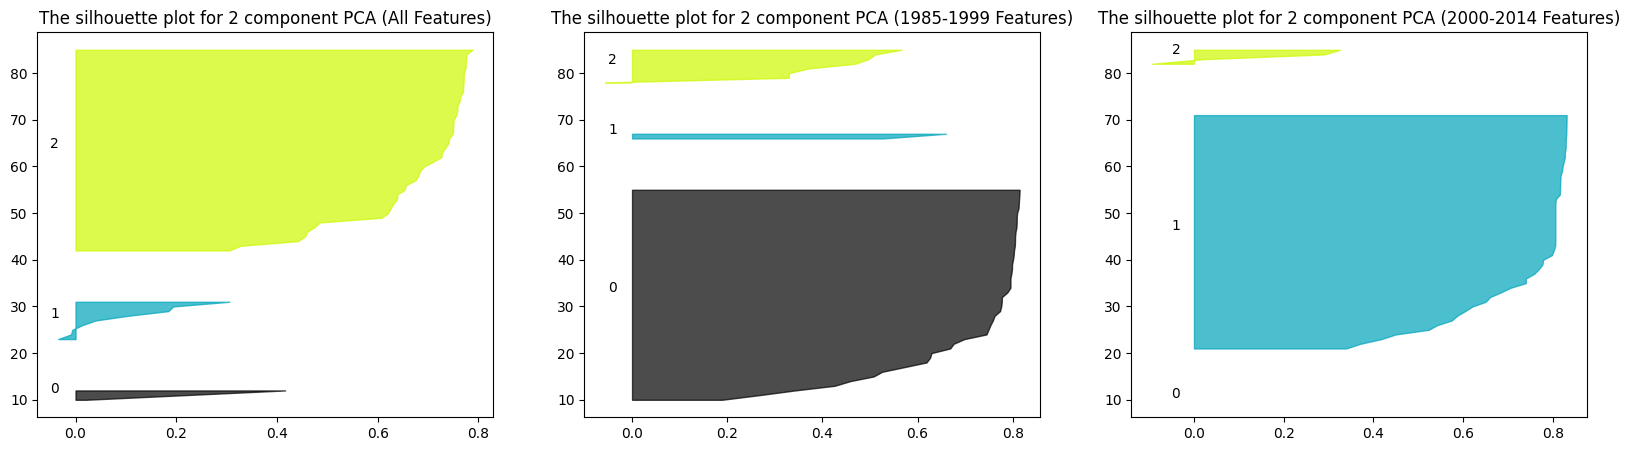

In [47]:
plt.figure(figsize=(20, 5)) 

plt.subplot(1,3,1)
silhouette_plot(data_scaled, kmeans, '2 component PCA (All Features)')
plt.subplot(1,3,2)
silhouette_plot(data_85_99_scaled, kmeans_85_99, '2 component PCA (1985-1999 Features)')
plt.subplot(1,3,3)
silhouette_plot(data_00_14_scaled, kmeans_00_14, '2 component PCA (2000-2014 Features)')

The above plot is the silhouette plot of the three models:
* For each cluster, the silhouette score of every instance in the cluster is plotted. 
* The higher the silhouette score, the better the instance matches the cluster. 
* Therefore, the more instances closer to 1, the bettering the clustering. 
* We won't go into more details here. 

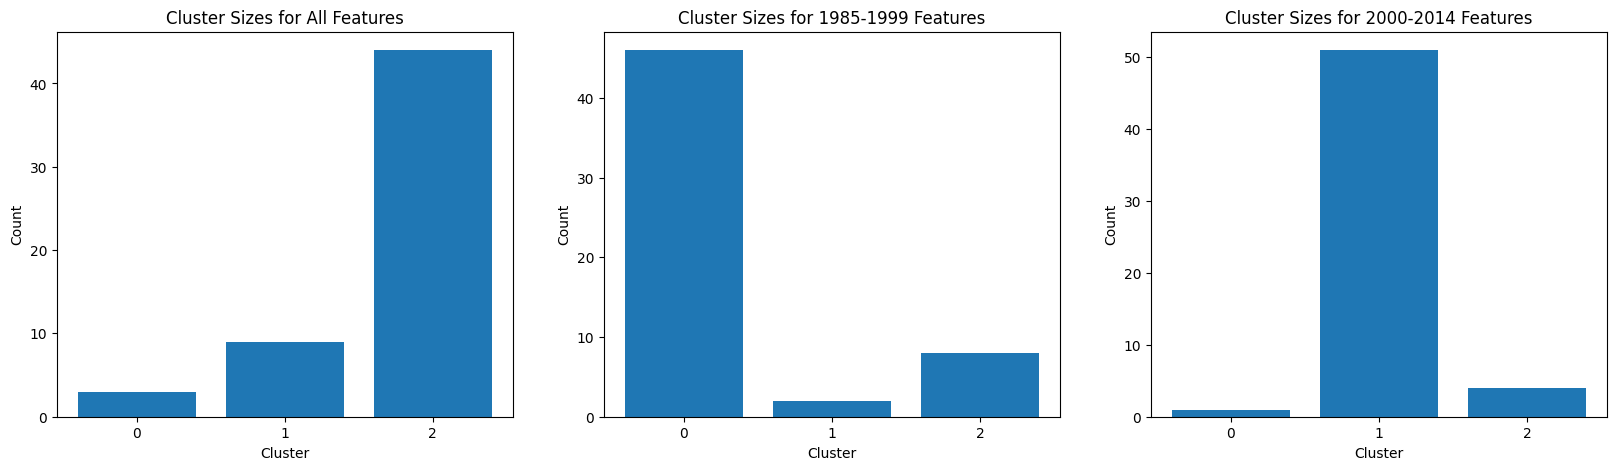

In [48]:
def cluster_size_plot(kmeans_model, title):
    clusters, counts = np.unique(kmeans_model.labels_, return_counts=True)
    plt.bar(clusters, counts, tick_label=clusters)
    plt.title('Cluster Sizes for ' + title)
    plt.xlabel('Cluster')
    plt.ylabel('Count')

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
cluster_size_plot(kmeans, 'All Features')
plt.subplot(1,3,2)
cluster_size_plot(kmeans_85_99, '1985-1999 Features')
plt.subplot(1,3,3)
cluster_size_plot(kmeans_00_14, '2000-2014 Features')

The above plot is a simple plot to visualise the size of the clusters for each model. As can be seen, for each model, there is a largest cluster for the safe airlines. 

### Task 5: K mean clustering with ratio of the variables from 2000-2014 divided by the respective variables from 1985-1999 and discussions

In [49]:
# Create new features
df_airline['incidents_ratio'] = df_airline['incidents_00_14'] / df_airline['incidents_85_99']
df_airline['fatal_accidents_ratio'] = df_airline['fatal_accidents_00_14'] / df_airline['fatal_accidents_85_99']
df_airline['fatalities_ratio'] = df_airline['fatalities_00_14'] / df_airline['fatalities_85_99']

# Replace any infinities or NaN values resulting from division by zero
df_airline = df_airline.replace([np.inf, -np.inf], np.nan)
df_airline = df_airline.dropna()

# Select the new features for K-means clustering
data_ratio = df_airline[['incidents_ratio', 'fatal_accidents_ratio', 'fatalities_ratio']]

# Scale the data
scaler = StandardScaler()
data_ratio_scaled = scaler.fit_transform(data_ratio)

# Perform K-means clustering
kmeans_ratio = KMeans(n_clusters=3, n_init=10, random_state=5508)
kmeans_ratio.fit(data_ratio_scaled)

df_airline['cluster_ratio'] = kmeans_ratio.labels_

Same as before, as the feature space is completely different for the different clustering models, we will not be comparing the performance metrics of the clustering, instead, the application and the meaning of the clusters will be investigated below. 

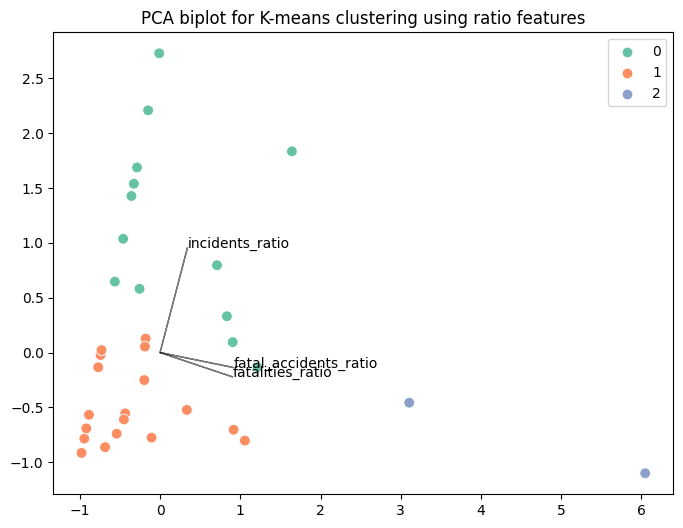

In [50]:
# Use PCA for visualization
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(data_ratio_scaled)

# Plotting the clusters
plt.figure(figsize=(8,6))
sns.scatterplot(x=principalComponents[:,0], y=principalComponents[:,1], hue=kmeans_ratio.labels_, palette="Set2", s=60)

# arrows for each feature
for i, feature in enumerate(['incidents_ratio', 'fatal_accidents_ratio', 'fatalities_ratio']):
    plt.arrow(0, 0, pca.components_[0, i]*np.sqrt(pca.explained_variance_[0]), pca.components_[1, i]*np.sqrt(pca.explained_variance_[1]), color='black',alpha=0.5)
    plt.text(pca.components_[0, i]*np.sqrt(pca.explained_variance_[0]), pca.components_[1, i]*np.sqrt(pca.explained_variance_[1]), feature)

plt.title('PCA biplot for K-means clustering using ratio features')
plt.show()

* A new clustering model is performed using the ratios of incident, fatality incident and fatality itself. 
* The ratio is calculated by dividing the 00-14 features by the 85-99 features. The new features represent the increase of incident rate over the years. 
* Three clusters are grouped as before. 
* The fatality accident ratio and fatality ratio are closer to each other on the biplot, indicating that they are more correlated with each other. 
* The three clusters are grouped based on the increase of incidents rates, increase of fatality accidents rate and increase in fatality occurances rate. 
* Cluster 1 has low increase in both accidents and fatality rate, cluster 0 has high increase in accidents rate, and mild increase in fatality rate. Cluster 2 only has high increase in fatality rate.
<br><br>
* The as can be seen, all the clusterings models that are used in this section are performing completely different tasks. 

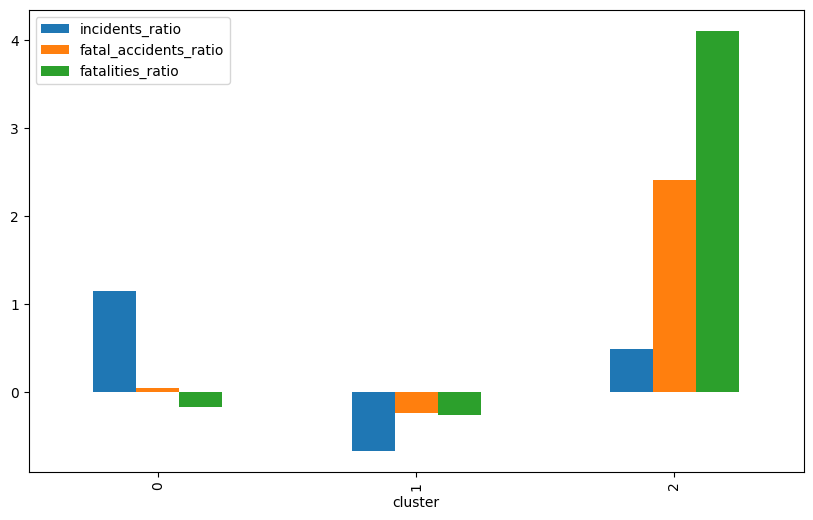

In [51]:
df_data_ratio_scaled = pd.DataFrame(data_ratio_scaled, columns=['incidents_ratio', 'fatal_accidents_ratio', 'fatalities_ratio'])
df_data_ratio_scaled['cluster'] = kmeans_ratio.labels_

# Compute cluster profiles
profiles_ratio = df_data_ratio_scaled.groupby('cluster').mean()

# Plot each profile
profiles_ratio.plot(kind='bar', figsize=(10, 6))

plt.show()

The above plot is the mean value of the scaled feature space for the different clustering in the last model:
* Cluster 1 has low ratio for the all three safety records, meaning that there is no increase in incidents rate over the years.
* Cluster 0 has high increase in general incidents rate, but only slightly high increase in fatality rate.
* Cluster 2 has slightly high increase in general incidences rate, but much higher increase in fatality rate.
<br><br>
* The models performed in task 2, task 4 and this task are doing completely different tasks because of the difference in the feature space. Depending on the application and the goal of the task, different clustering models should be used. 

# Section 3: A clustering analysis on the USArrests data <br>

### Task 1: Hierarchical clustering with complete linkage using unscaled data

In [52]:
import pandas as pd

df_us = pd.read_csv('USArrests.csv')

In [53]:
df_us.head()

,State,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [54]:
# To see the total number of missing values in the entire DataFrame
total_missing_values = df_us.iloc[:,1:].isna().sum().sum()
print(f"\nTotal missing values in DataFrame: {total_missing_values}")


Total missing values in DataFrame: 0


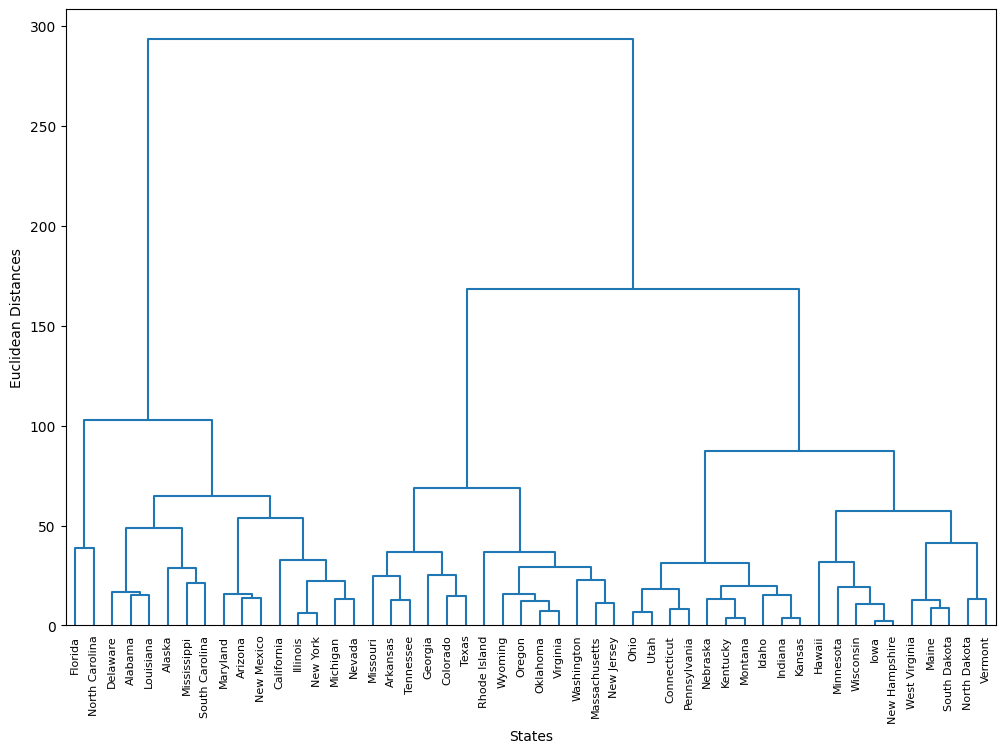

In [55]:
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
import matplotlib.pyplot as plt
# perform Hierarchical clustering on unscaled data
Z = linkage(df_us.iloc[:,1:], 'complete')
plt.figure(figsize=(12, 8))
dendrogram(Z, labels = df_us.iloc[:, 0].values, color_threshold = 0)
plt.xlabel('States')
plt.ylabel('Euclidean Distances')
plt.show()

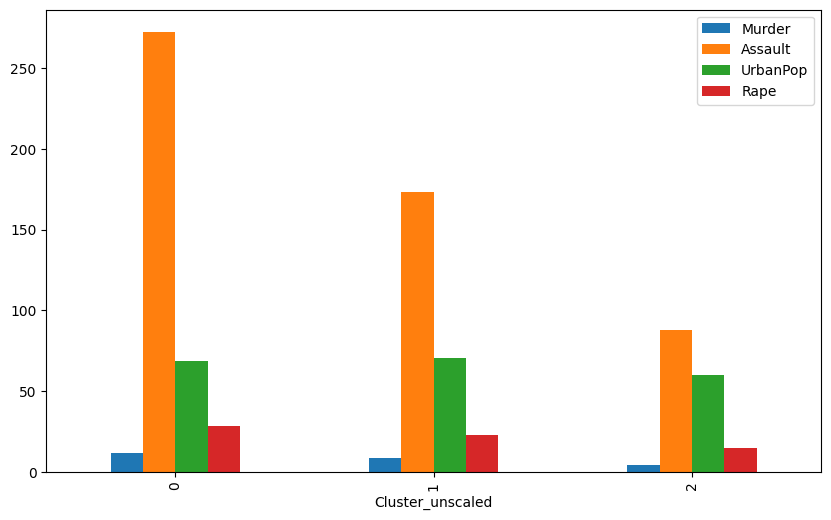

In [56]:
# clusters = fcluster(Z, t = 3, criterion='distance')
# cut tree at n = 3
clusters = cut_tree(Z, n_clusters=3)
df_clustered_unscaled = df_us.copy()
df_clustered_unscaled['Cluster_unscaled'] = clusters
cluster_characteristics = df_clustered_unscaled.groupby('Cluster_unscaled').mean(numeric_only=True)
# print(cluster_characteristics)
# Plot each profile
cluster_characteristics.plot(kind='bar', figsize=(10, 6))
plt.show()

The above plot is the average feature values of each cluster:
* The hierarchical clustering is performed on the unscaled data
* Cluster 0 has the highest crime incident numbers for all categories -- murder, assault, and rape. Cluster 1 has medium number of crime incidents, while cluster 2 has the lowest number of crime accidents in all categories. 
* All three clusters have similar urban population. 
* The hierarchical clustering separated the states according to their total crime incident number. 
<br><br>
* To see which states belongs to which cluster, we will create a pca biplot later on.

In [57]:
# Some more detailed statistics on the crime numbers for each cluster. We will not go into details here
for i in np.unique(clusters):
    print(f"\nCluster {i}:")
    print(df_clustered_unscaled[df_clustered_unscaled['Cluster_unscaled'] == i].iloc[:,:-1].describe())


Cluster 0:
         Murder     Assault   UrbanPop       Rape
count  16.00000   16.000000  16.000000  16.000000
mean   11.81250  272.562500  68.312500  28.375000
std     2.79592   31.052576  15.490723   9.602882
min     5.90000  236.000000  44.000000  15.800000
25%    10.30000  251.250000  55.500000  21.950000
50%    11.75000  261.000000  71.000000  26.950000
75%    13.50000  287.250000  80.250000  32.850000
max    16.10000  337.000000  91.000000  46.000000

Cluster 1:
          Murder     Assault   UrbanPop       Rape
count  14.000000   14.000000  14.000000  14.000000
mean    8.214286  173.285714  70.642857  22.842857
std     3.944199   22.182559  11.849097   7.402361
min     3.400000  145.000000  50.000000   8.300000
25%     5.325000  156.750000  60.750000  18.975000
50%     7.650000  167.500000  69.000000  23.100000
75%     8.950000  189.500000  79.500000  26.725000
max    17.400000  211.000000  89.000000  38.700000

Cluster 2:
          Murder    Assault   UrbanPop       Rape
count

Explained variance by first 2 principal components: 99.34%


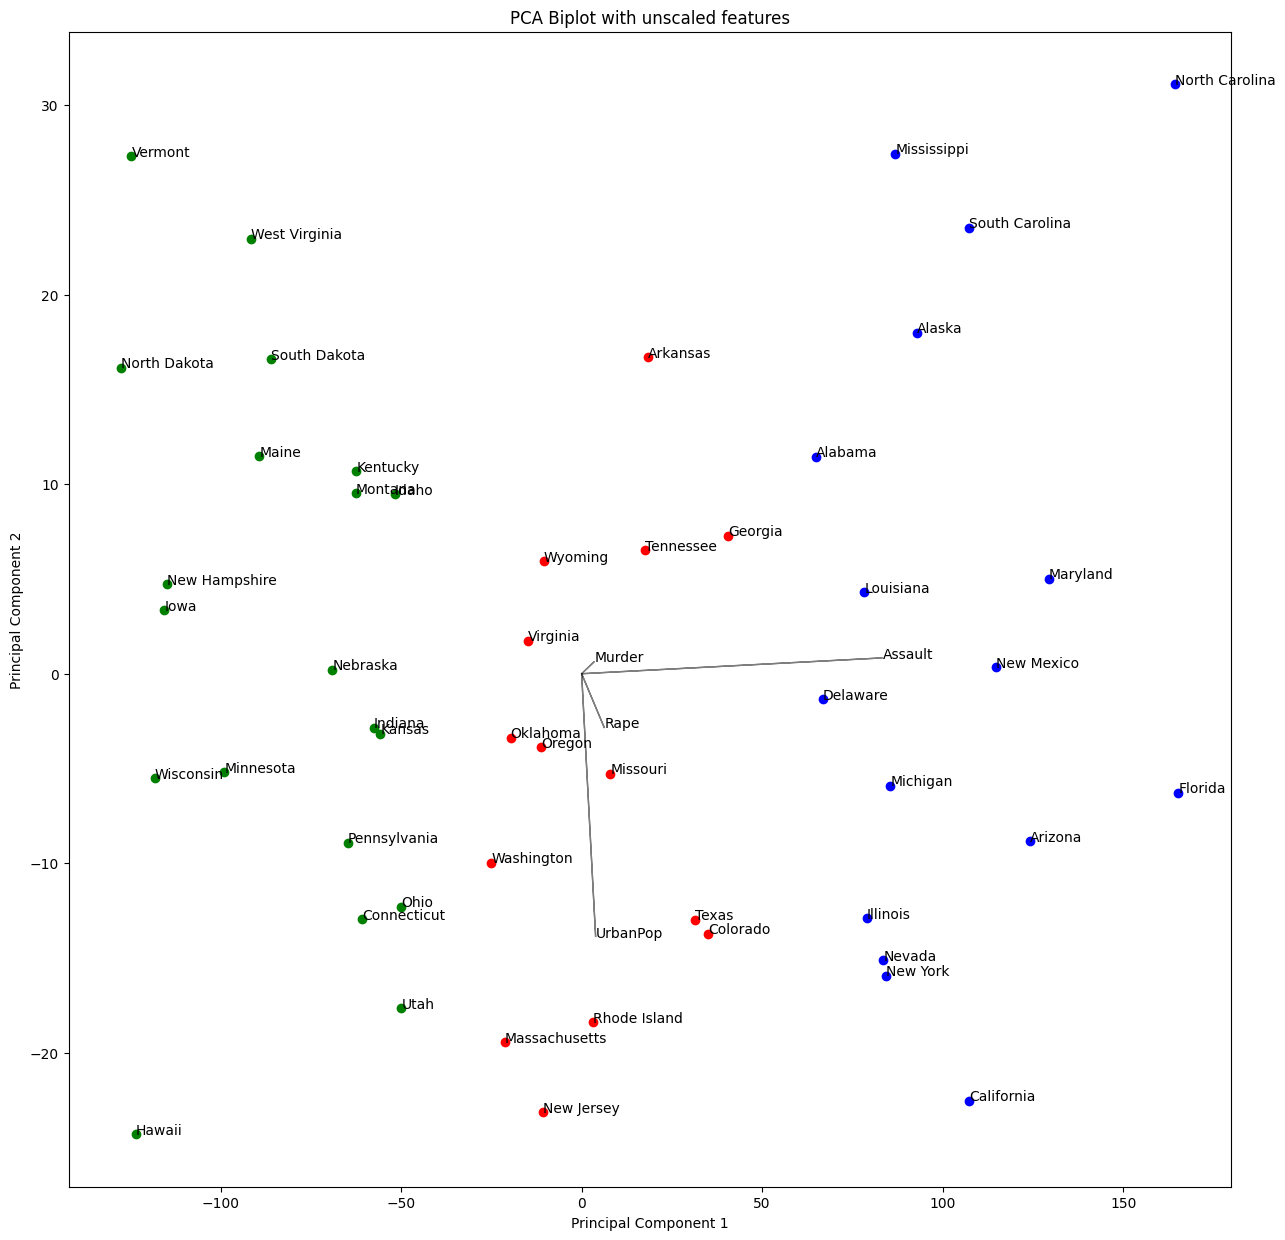

In [58]:
# Initialize PCA with the first two components
pca = PCA(n_components=2)

# Fit and transform the data
pca_result = pca.fit_transform(df_us.iloc[:, 1:])

# Print explained variance
print('Explained variance by first 2 principal components: {:.2%}'.format(sum(pca.explained_variance_ratio_)))

# Create a new dataframe with the PCA result and the cluster assignments
df_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
df_pca['Cluster'] = clusters
df_pca['State'] = df_us.iloc[:, 0]

# Plotting
plt.figure(figsize=(15,15))
colors = ['r', 'g', 'b']
for cluster in np.unique(clusters):
    plt.scatter(df_pca[df_pca['Cluster'] == cluster]['PC1'], df_pca[df_pca['Cluster'] == cluster]['PC2'], c = colors[cluster-1])
    for i, txt in enumerate(df_pca[df_pca['Cluster'] == cluster]['State']):
        plt.annotate(txt, (df_pca[df_pca['Cluster'] == cluster]['PC1'].iloc[i], df_pca[df_pca['Cluster'] == cluster]['PC2'].iloc[i]))

# arrows for each feature
for i, feature in enumerate(df_us.columns[1:]):
    plt.arrow(0, 0, pca.components_[0, i]*np.sqrt(pca.explained_variance_[0]), pca.components_[1, i]*np.sqrt(pca.explained_variance_[1]), color='black',alpha=0.5)
    plt.text(pca.components_[0, i]*np.sqrt(pca.explained_variance_[0]), pca.components_[1, i]*np.sqrt(pca.explained_variance_[1]), feature)
    
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Biplot with unscaled features')
plt.show()

The above is the biplot of the hierarchical using unscaled feature space:
* One thing that was immediately notices was that the assault and urbanpop features have much higher weight comparing with the other two features. This is because numerically they are of higher range of values comparing with murder and rape. And the hierarchical clustering is trained on the unscaled data. 
* In the next task, we will scaled the feature space and train the model.
* As can be seen on the plot, the murder, assault, and rape (crime features) features are positively correlately with the first principle component. The urban population is less correlated with the first PC, but negatively related to the second PC. 
* All the states are categorised into three clusters, the first cluster on the left side of the plot has the lowest number of crime rate, the middle cluster has medium number of crime rate and the cluster on the right has the highest number of crime rate. 
* As can be seen, there is not too much clustering with respect to the second principle component, meaning that the three clusters are more considering the crime rate, regardless of the urban population of that state. 
* Some states like Hawaii, it has a high urban population, but veyr small crime rate.
* Some states like california, there is a high rate of crime, but also high number of urban population.
* Some states like north carolina, there is a low number of urban population, but high number of crime rate.

### Task 2: Hierarchical clustering with complete linkage using scaled data

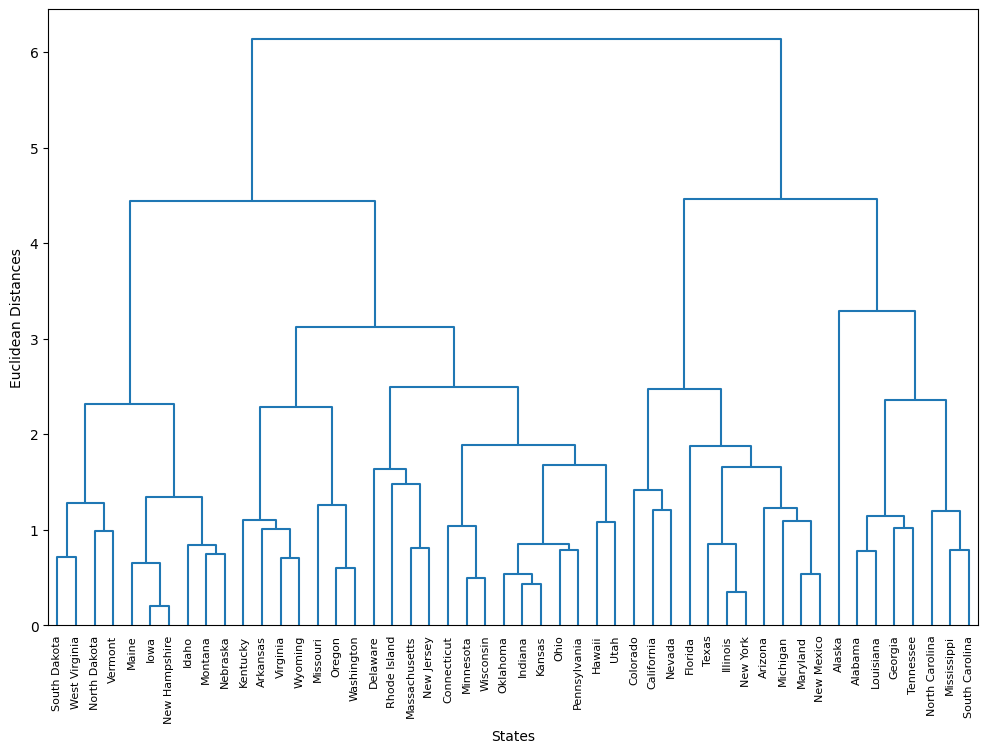

In [59]:
# Scale the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_us.iloc[:,1:])
df_scaled = pd.DataFrame(data_scaled, columns=df_us.columns[1:])

Z = linkage(df_scaled, 'complete')
plt.figure(figsize=(12, 8))
dendrogram(Z, labels = df_us.iloc[:, 0].values, color_threshold = 0)
plt.xlabel('States')
plt.ylabel('Euclidean Distances')
plt.show()

* From the dendrogram, we can see that the distribution of the clustering union is a lot more balanced with the scaled data. 
* Previously, the assault and urbanpop data has much larger scaled comparing with murder and rape. The larger scale features has a big impact on the clustering algorithm when distance between instance is calculated. 
* Now that we scale the data, all features are considered equally important to the clustering algorithm.

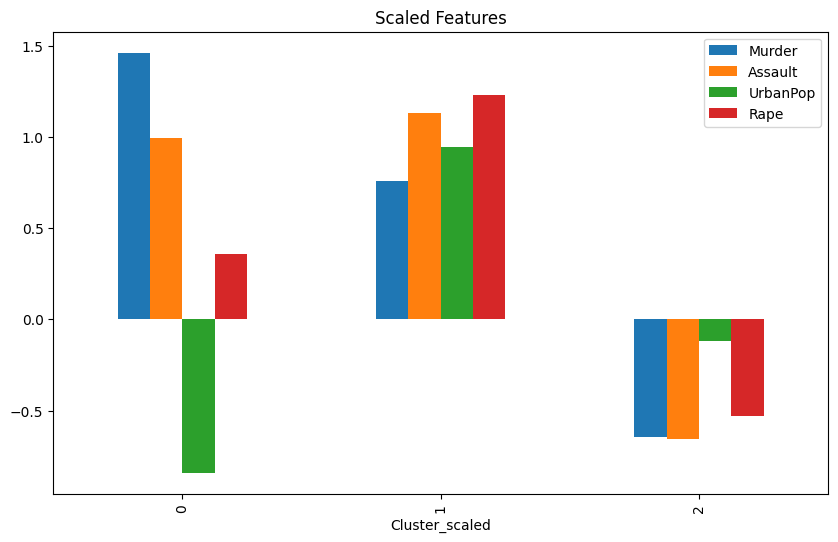

In [60]:
# clusters = fcluster(Z, t = 3, criterion='distance')
clusters = cut_tree(Z, n_clusters=3)
df_clustered_scaled = df_scaled.copy()
df_clustered_scaled['Cluster_scaled'] = clusters
df_clustered_unscaled['Cluster_scaled'] = clusters

cluster_characteristics = df_clustered_scaled.groupby('Cluster_scaled').mean(numeric_only=True)
# print(cluster_characteristics)
# Plot each profile
cluster_characteristics.plot(kind='bar', figsize=(10, 6), title="Scaled Features")

# cluster_characteristics = df_clustered_unscaled.groupby('Cluster_scaled').mean(numeric_only=True)[df_us.columns[1:]]
# cluster_characteristics.plot(kind='bar', figsize=(10, 6), title="Unscaled Features")

plt.show()

Above is the mean value of features for each cluster:
* As can be seen, cluster 0 has the lowest urban population, the highest number of murder and middle cases of assault and rape.
* Cluster 1 has the highest urban population, middle number of  murder, and the highest number for assault and rape. 
* cluster 2 has the lowerst urban population, and the lowest crime incident from all aspects.
* The new clustering is taken more factors into consideration for each group. 
<br><br>
* Below, we will plot two pca biplots using the new scaled features and the original features.

In [61]:
# for i in np.unique(clusters):
#     print(f"\nCluster {i}:")
#     print(df_clustered_scaled[df_clustered_scaled['Cluster_scaled'] == i].iloc[:,:-1].describe())

Explained variance by first 2 principal components: 86.75%


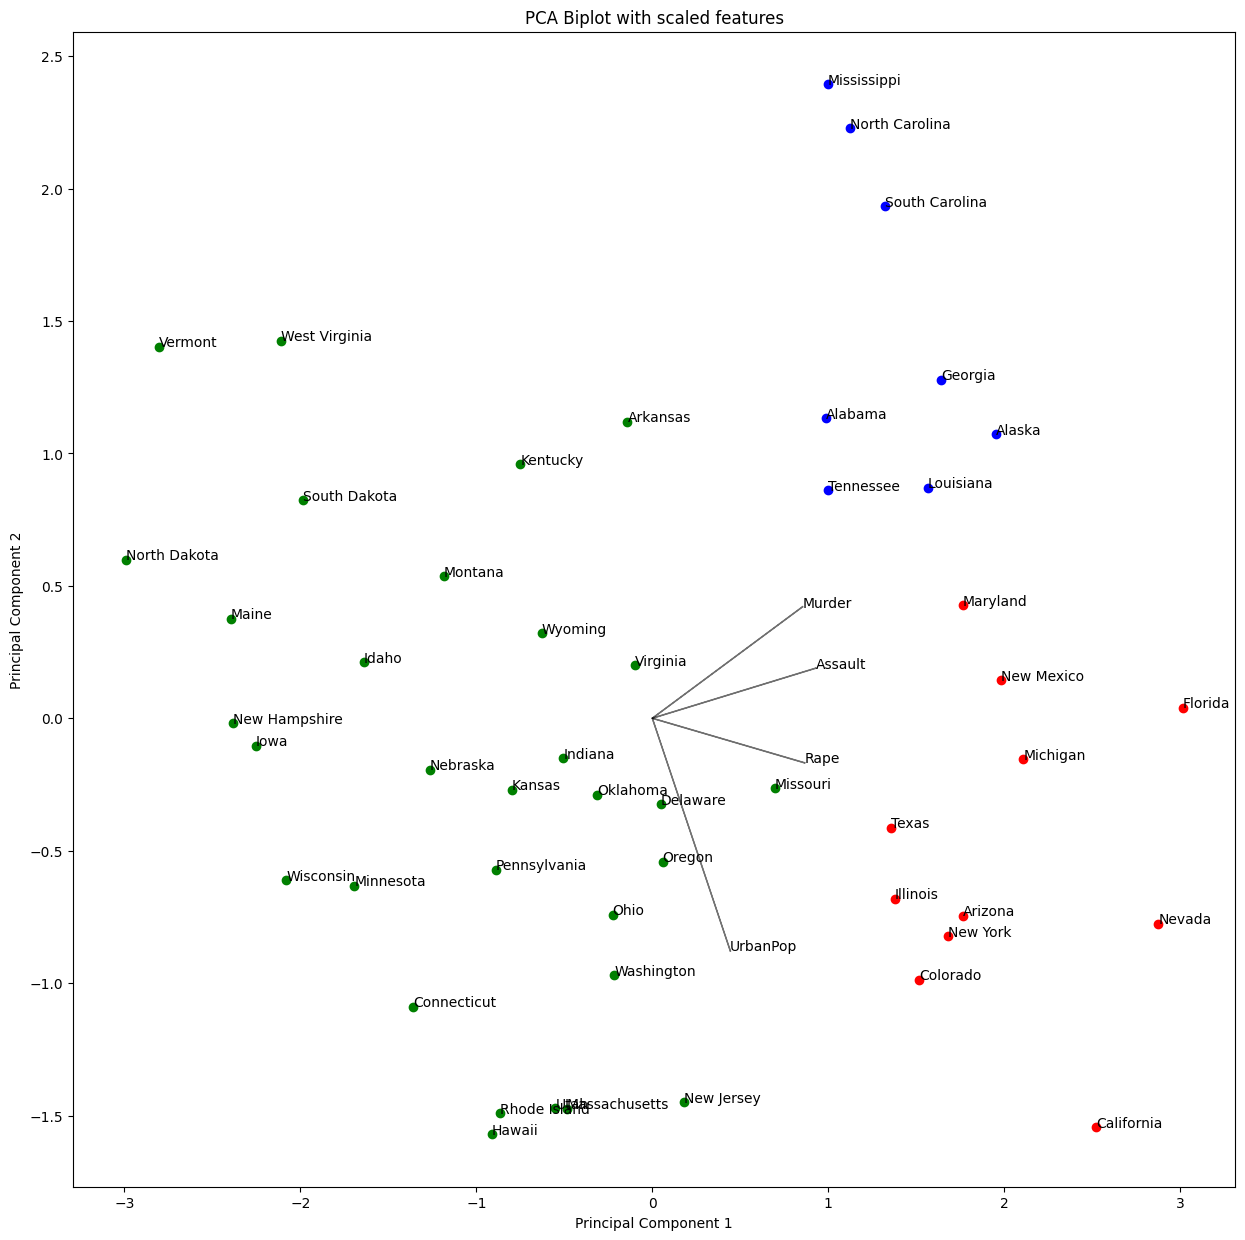

In [62]:
# Initialize PCA with the first two components
pca = PCA(n_components=2)

# Fit and transform the data
pca_result = pca.fit_transform(df_scaled)

# Print explained variance
print('Explained variance by first 2 principal components: {:.2%}'.format(sum(pca.explained_variance_ratio_)))

# Create a new dataframe with the PCA result and the cluster assignments
df_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
df_pca['Cluster'] = clusters
df_pca['State'] = df_us.iloc[:, 0]

# Plotting
plt.figure(figsize=(15,15))
colors = ['r', 'g', 'b']
for cluster in np.unique(clusters):
    plt.scatter(df_pca[df_pca['Cluster'] == cluster]['PC1'], df_pca[df_pca['Cluster'] == cluster]['PC2'], c = colors[cluster-1])
    for i, txt in enumerate(df_pca[df_pca['Cluster'] == cluster]['State']):
        plt.annotate(txt, (df_pca[df_pca['Cluster'] == cluster]['PC1'].iloc[i], df_pca[df_pca['Cluster'] == cluster]['PC2'].iloc[i]))

# arrows for each feature
for i, feature in enumerate(df_us.columns[1:]):
    plt.arrow(0, 0, pca.components_[0, i]*np.sqrt(pca.explained_variance_[0]), pca.components_[1, i]*np.sqrt(pca.explained_variance_[1]), color='black',alpha=0.5)
    plt.text(pca.components_[0, i]*np.sqrt(pca.explained_variance_[0]), pca.components_[1, i]*np.sqrt(pca.explained_variance_[1]), feature)
    
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Biplot with scaled features')
plt.show()

Above is the PCA biplot using the principle components of the scaled features. 
* As can be seen, the previous clustering from task 1 was not really taking the urban population into consideration (as the scale is so long, they are not being priorily grouped). Now, with the new scaled feature space, the urban population is taken into consideration and is affecting the clustering results. 
* The length of the features on the biplot is also of similar length now, as the features are scaled. All features have similar contribution to the clustering. 
* From the biplot, we can infer the following informaiton. 
* The green cluster on the left is still the low crime rate group. Here to note that it is allowing some of the states with slightly higher crime rate but high urban population as well into the cluster. 
* The blue and red groups are the two high crime rate group. This time, it is also taking the type of crime into consideration. The blue group has higher rate of the more severe crimes -- murder, and the red group have moore assault and rape, and medium rate of murder. 
* The scaling has changed the weights on each features, and in my personally opinion it is doing a more comprehensive clustering scaling taking more features into consideration. Previously the model was not really taking urban population into consideration, and the different types of crime is not separated well either. The new clustering is giving more information. 
* Depending on the application and the goal of the clustering task, the scaling the the feature space can be ajusted.
<br><br>
* Below is another pca biplot using the original unscaled principle components and features. It is only plotted to compare the change in clustering with task 1.

Explained variance by first 2 principal components: 99.34%


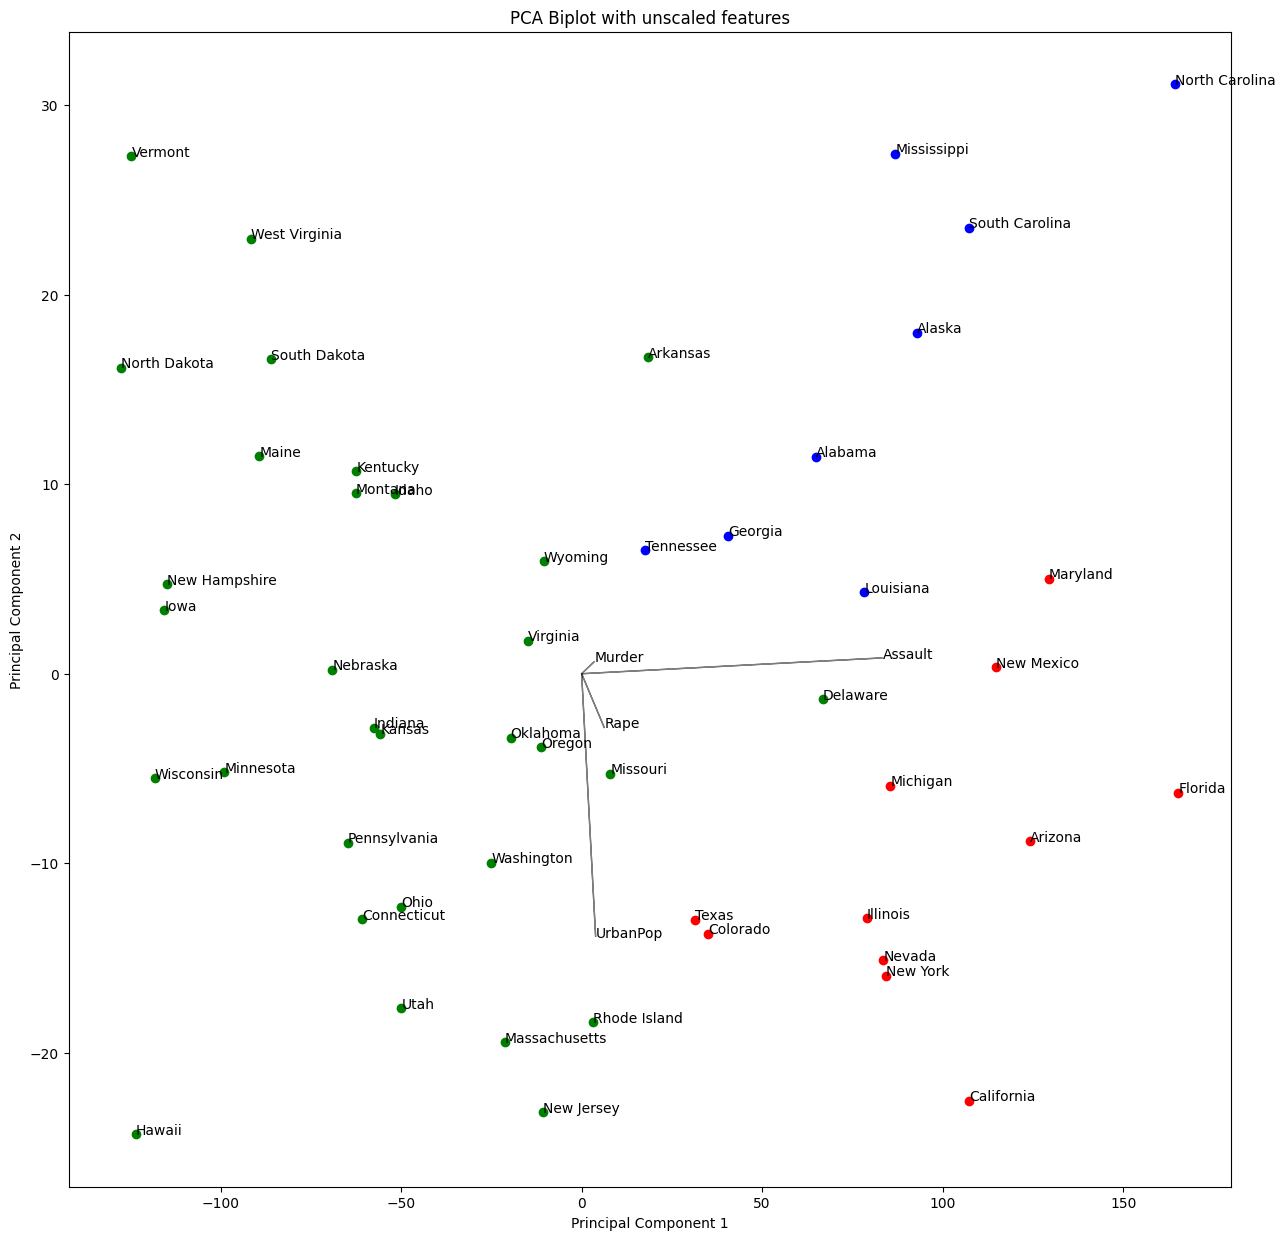

In [63]:
# Initialize PCA with the first two components
pca = PCA(n_components=2)

# Fit and transform the data
pca_result = pca.fit_transform(df_us.iloc[:,1:])
# Print explained variance
print('Explained variance by first 2 principal components: {:.2%}'.format(sum(pca.explained_variance_ratio_)))
# Create a new dataframe with the PCA result and the cluster assignments
df_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
df_pca['Cluster'] = clusters
df_pca['State'] = df_us.iloc[:, 0]

# Plotting
plt.figure(figsize=(15,15))
colors = ['r', 'g', 'b']
for cluster in np.unique(clusters):
    plt.scatter(df_pca[df_pca['Cluster'] == cluster]['PC1'], df_pca[df_pca['Cluster'] == cluster]['PC2'], c = colors[cluster-1])
    for i, txt in enumerate(df_pca[df_pca['Cluster'] == cluster]['State']):
        plt.annotate(txt, (df_pca[df_pca['Cluster'] == cluster]['PC1'].iloc[i], df_pca[df_pca['Cluster'] == cluster]['PC2'].iloc[i]))

# arrows for each feature
for i, feature in enumerate(df_us.columns[1:]):
    plt.arrow(0, 0, pca.components_[0, i]*np.sqrt(pca.explained_variance_[0]), pca.components_[1, i]*np.sqrt(pca.explained_variance_[1]), color='black',alpha=0.5)
    plt.text(pca.components_[0, i]*np.sqrt(pca.explained_variance_[0]), pca.components_[1, i]*np.sqrt(pca.explained_variance_[1]), feature)
    
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Biplot with unscaled features')
plt.show()

Above is another pca biplot using the original unscaled principle components and features. It is only plotted to compare the change in clustering with task 1.
* Comparing with the plot from task 1, states like delaware, that was categorised into high crime rate by the task 1 is now classified into low crime rate by task 2. 
* The clustering of the states around the middle of the biplot has changed a lot by the scaling of the features. however, states like North carolina with very bad crime rates are still in the same "bad" group. 

### Task 3: Hierarchical clustering with complete linkage using PCA

In [64]:
from sklearn.decomposition import PCA
# performing pca on the scaled data
pca = PCA(n_components=2)
df_pca = pd.DataFrame(pca.fit_transform(df_scaled), columns=['PC1', 'PC2'])
# Print explained variance
print('Explained variance by first 2 principal components: {:.2%}'.format(sum(pca.explained_variance_ratio_)))
Z_pca = linkage(df_pca, method='complete', metric='euclidean')

# Cut the dendrogram to create clusters
df_pca['Cluster'] = cut_tree(Z_pca, n_clusters=3)


Explained variance by first 2 principal components: 86.75%


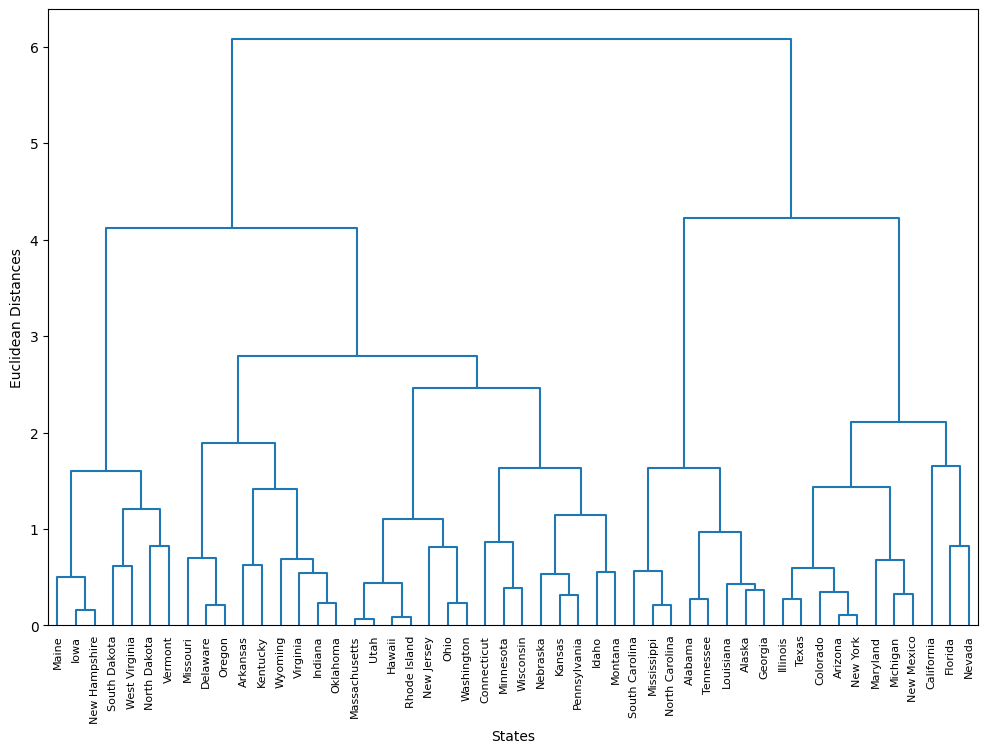

In [65]:
plt.figure(figsize=(12, 8))
dendrogram(Z_pca, labels = df_us.iloc[:, 0].values, color_threshold = 0)
plt.xlabel('States')
plt.ylabel('Euclidean Distances')
plt.show()

* the pca is performed on the scaled data, so the dendrogram still look quite balanced

Explained variance by first 2 principal components: 86.75%


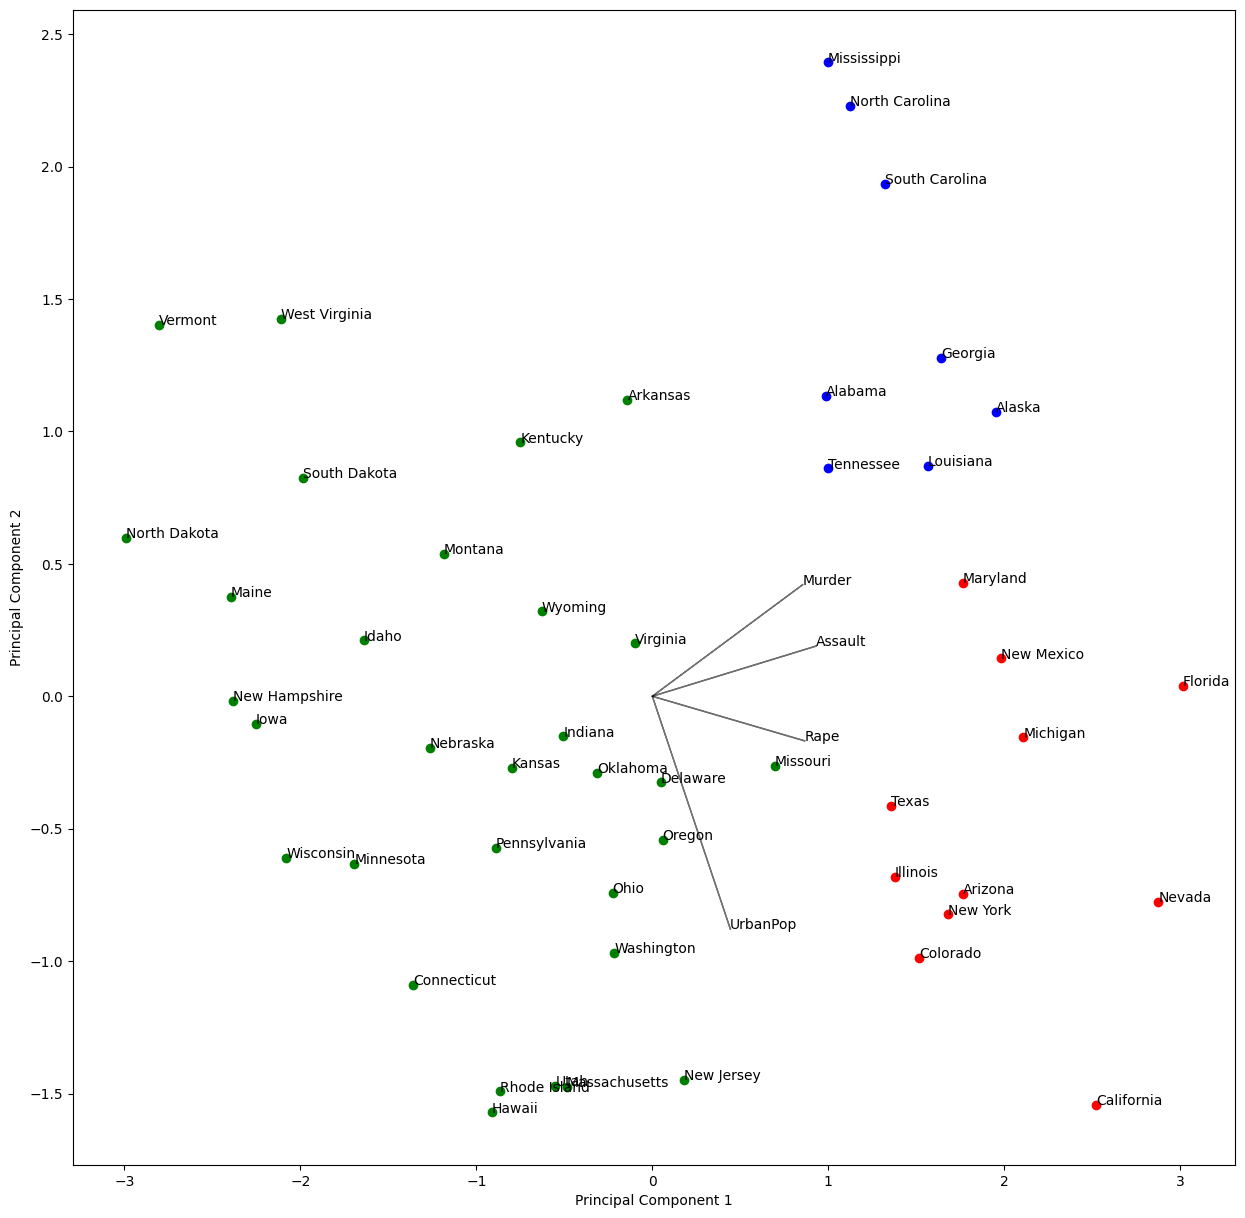

In [66]:
df_pca['State'] = df_us.iloc[:, 0]
# Print explained variance
print('Explained variance by first 2 principal components: {:.2%}'.format(sum(pca.explained_variance_ratio_)))

plt.figure(figsize=(15, 15))
# for i, cluster in df_pca.groupby('Cluster'):
#     plt.scatter(cluster['PC1'], cluster['PC2'], label=f'Cluster {i}')
colors = ['r', 'g', 'b']
for cluster in np.unique(df_pca['Cluster']):
    plt.scatter(df_pca[df_pca['Cluster'] == cluster]['PC1'], df_pca[df_pca['Cluster'] == cluster]['PC2'], c = colors[cluster-1])
    for i, txt in enumerate(df_pca[df_pca['Cluster'] == cluster]['State']):
        plt.annotate(txt, (df_pca[df_pca['Cluster'] == cluster]['PC1'].iloc[i], df_pca[df_pca['Cluster'] == cluster]['PC2'].iloc[i]))
        
# arrows for each feature
for i, feature in enumerate(df_us.columns[1:]):
    plt.arrow(0, 0, pca.components_[0, i]*np.sqrt(pca.explained_variance_[0]), pca.components_[1, i]*np.sqrt(pca.explained_variance_[1]), color='black',alpha=0.5)
    plt.text(pca.components_[0, i]*np.sqrt(pca.explained_variance_[0]), pca.components_[1, i]*np.sqrt(pca.explained_variance_[1]), feature)
    
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


The above is the pca biplot of the scaled features, trained on the first 2 principle components:
* The clustering trained on the first two principle component of the scaled features (task 3), and train on the scaled features itself (task 2) give exactly the same clustering. 
* This biplot is exactly the same as the biplot produced in task 2 using the first two principle component of the scale features, but trained on the scaled features themselves.
* This means that, the first two principle component with 87% variance explained is enough to perform the same level of the clustering as the full feature space. 
* The dimensionanlity reduction is as good as the original feature space in this case. 
* For more details on the meaning of the clustering please refer to task 2.
* As this is the same as the task 2 clustering, for explanations on how it is different from task 1, please refer to the explanations in task 2. 

### Task 4: K-means clustering (with K=3) using the first two principal components and the group means obtained from the hierarchical clustering

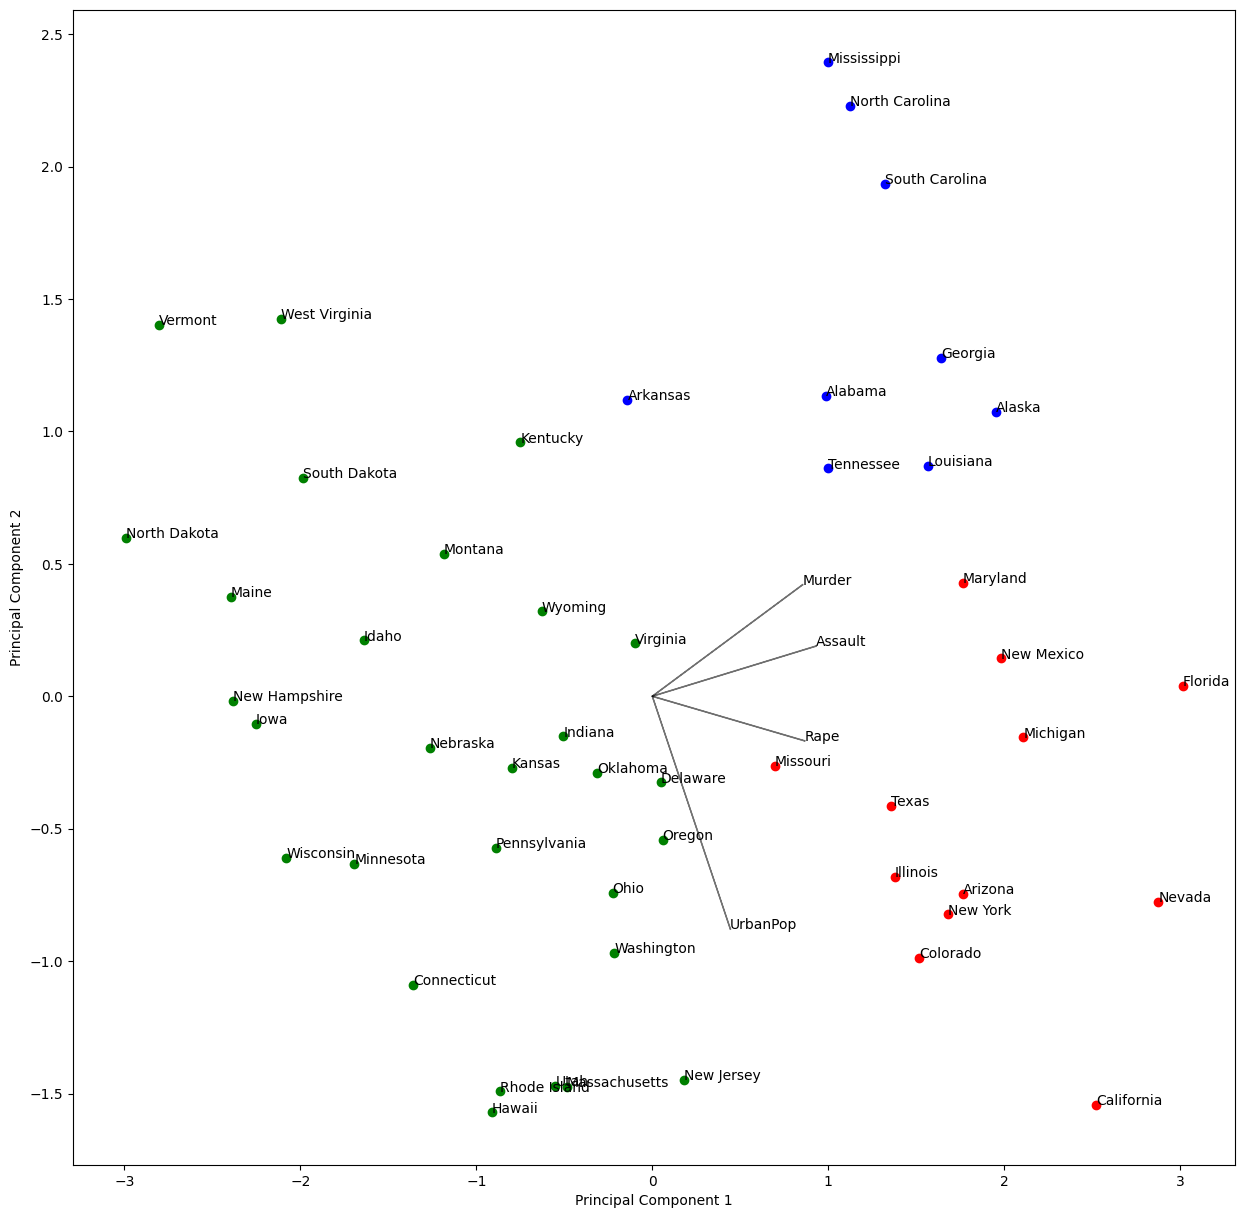

In [67]:
# Get cluster means from hierarchical clustering on PCA
cluster_means = df_pca.groupby('Cluster').mean(numeric_only=True)[['PC1', 'PC2']]

# Use these means as initial centroids for K-means with only 1 initiation. 
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, init=cluster_means, n_init=1, random_state=5508)
kmeans.fit(df_pca[['PC1', 'PC2']])


df_pca['KMeans_Cluster'] = kmeans.labels_
# df_pca['State'] = df_us.iloc[:, 0]

plt.figure(figsize=(15, 15))
# for i, cluster in df_pca.groupby('KMeans_Cluster'):
#     plt.scatter(cluster['PC1'], cluster['PC2'], label=f'Cluster {i}')
colors = ['r', 'g', 'b']
for cluster in np.unique(df_pca['KMeans_Cluster']):
    plt.scatter(df_pca[df_pca['KMeans_Cluster'] == cluster]['PC1'], df_pca[df_pca['KMeans_Cluster'] == cluster]['PC2'], c = colors[cluster-1])
    for i, txt in enumerate(df_pca[df_pca['KMeans_Cluster'] == cluster]['State']):
        plt.annotate(txt, (df_pca[df_pca['KMeans_Cluster'] == cluster]['PC1'].iloc[i], df_pca[df_pca['KMeans_Cluster'] == cluster]['PC2'].iloc[i]))
# arrows for each feature
for i, feature in enumerate(df_us.columns[1:]):
    plt.arrow(0, 0, pca.components_[0, i]*np.sqrt(pca.explained_variance_[0]), pca.components_[1, i]*np.sqrt(pca.explained_variance_[1]), color='black',alpha=0.5)
    plt.text(pca.components_[0, i]*np.sqrt(pca.explained_variance_[0]), pca.components_[1, i]*np.sqrt(pca.explained_variance_[1]), feature)
    
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


The result of the K mean clustering in task 4 is very similar to the hierarchical clustering in task 3:
* Both clustering are performed using the first two principle components of the scaled feature space.
* The K means clustering is using the centroids from the task 3 hierarchical clustering. 
* The general structure of the three clusters are the same as task 3. The charateristics of the three clusters are similar to task 2 and 3.
* There are only two instances on the boundary of the clusters that are different from task 3.
* Arkansas was previously clusters with the green -- low crime rate group by task 3, it is now clustered with high murder rate group, due to its mildly higher murder rate.
* Missouri was previously clustered with the green -- low crime rate group by task 3, it is now clustered with high rape & assault group, due to its mildly higher assault and rape rate.
* The general nature of the three clusters are still the same by looking at the biplot, only two instance on the boundary was changed. 
<br><br>
* There is no absolute saying to judge which clustering is better. It depends on the application of the task. 
* It's important to know that hierarchical clustering and K-means clustering have different advantages and disadvantages. Hierarchical clustering doesn't need to know the number of clusters beforehand and creates a tree-like diagram (dendrogram) that helps see the data's structure. On the other hand, K-means can be faster for big datasets and makes it easy to update the clusters when new data comes in.
* There is no one "best" method that works for all situations. The most suitable method depends on the unique features of the data and what we need to accomplish with the analysis.
* for example, if we would like to pick more high crime rate states with high sensitivity, then in this case, the K means is better. If we only want the high crime rate states and leaving out the ones on the boundary, then hierarchical clustering can be used.
<br><br>
* The last cell below is just numerically showing the different between the two clustering from task 3 and 4, confirming the biplot. 

In [68]:
pd.crosstab(df_pca['Cluster'], df_pca['KMeans_Cluster'])

KMeans_Cluster,0,1,2
Cluster,,,
0,8,0,0
1,0,11,0
2,1,1,29
